In [1]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [2]:
client = InfluxDBClient(host='140.112.42.160', port=23234, database='test_2')

In [3]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [4]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def get_edge_list(result):
    record = list()
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            record.append(edges)
    return record


Observe the lifetime of servers

In [5]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
sample_time1 = ['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']
sample_time2 = ['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', '23:59:59']

In [6]:
st = f'2019-10-28T00:00:00Z' 
et = f'2019-11-10T23:59:59Z'
q = build_query(st, et, loc='west-us', lang=None)
result = client.query(q)
server_set, _ = get_edge_num(result)
server_list = list(server_set)
print(len(server_set))
print(len(server_list))

197
197


Baseline

In [7]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']

In [8]:
BS_24hr_12am_us_1day = np.zeros((len(date),), dtype = int)
BS_24hr_12am_us_1day_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12am_eu_1day = np.zeros((len(date),), dtype = int)
BS_24hr_12am_eu_1day_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12am_us_2day = np.zeros((len(date)//2,), dtype = int)
BS_24hr_12am_us_2day_tran = np.zeros((len(date)//2,), dtype = int)
BS_24hr_12am_eu_2day = np.zeros((len(date)//2,), dtype = int)
BS_24hr_12am_eu_2day_tran = np.zeros((len(date)//2,), dtype = int)

In [9]:
def get_server_ip_bs(d1, d2, t1, t2, loc, lang=None):
    st = f'2019-{d1}T{t1}:00:00Z' 
    et = f'2019-{d2}T{t2}:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    BS, BS_t = get_edge_num(result)
    return len(BS), BS_t


In [10]:
#24hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-us')
    BS_24hr_12am_us_1day[d] = num
    BS_24hr_12am_us_1day_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-eu')
    BS_24hr_12am_eu_1day[d] = num
    BS_24hr_12am_eu_1day_tran[d] = tran

for d, (date1, date2) in enumerate(zip(date[:-1], date_1[1:])):
    if d % 2 == 1:
        continue
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-us')
    BS_24hr_12am_us_2day[d//2] = num
    BS_24hr_12am_us_2day_tran[d//2] = tran
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-eu')
    BS_24hr_12am_eu_2day[d//2] = num
    BS_24hr_12am_eu_2day_tran[d//2] = tran
    
print(BS_24hr_12am_us_1day)
print(np.std(BS_24hr_12am_us_1day))
print(np.std(BS_24hr_12am_us_1day) / np.mean(BS_24hr_12am_us_1day))
print(BS_24hr_12am_us_1day_tran)
print(BS_24hr_12am_eu_1day)
print(np.std(BS_24hr_12am_eu_1day))
print(np.std(BS_24hr_12am_eu_1day) / np.mean(BS_24hr_12am_eu_1day))
print(BS_24hr_12am_eu_1day_tran)
print(BS_24hr_12am_us_2day)
print(BS_24hr_12am_us_2day_tran)
print(BS_24hr_12am_eu_2day)
print(BS_24hr_12am_eu_2day_tran)

[131 135 131 132 141 128 152 133 140 152 128 130 131 129]
7.830148433445941
0.0579091801733984
[331715 363885 341492 320152 327913 315358 291054 320451 317502 278662
 284515 212132 260809 264912]
[546 574 566 544 566 589 680 607 653 584 599 601 534 695]
47.647086982933004
0.0800023048406167
[331133 358949 338818 315757 332171 291484 284945 307217 312219 280142
 279455 208486 248266 257614]
[140 138 142 158 161 132 134]
[695600 661644 643271 611505 596164 496647 525721]
[645 605 629 695 682 660 708]
[690082 654575 623655 592162 592361 487941 505880]


In [46]:
error_rate_avg_12am = np.zeros((4, 5))
error_rate_std_12am = np.zeros((4, 5))
error_rate_avg_12pm = np.zeros((4, 5))
error_rate_std_12pm = np.zeros((4, 5))
transaction_avg_12am = np.zeros((4, 5))
transaction_avg_12pm = np.zeros((4, 5))

In [291]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']

In [33]:
import random

def get_server_ip_sampling(drop, date, t1, t2, idx, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    if drop == 0:
        C, C_t = get_edge_num(result)
    else:
        ip_list = get_edge_list(result)
        random.shuffle(ip_list)
        ip_set = []
        for ips in ip_list[int(drop*len(ip_list)):]:
            for ip in ips:
                ip_set.append(ip)
        C = set(ip_set)
    
    last_rec = np.zeros((idx,), dtype = int)
    marked_sum = 0
    if idx > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[idx, :idx] = last_rec[::-1]
        
    m_t[idx] = marked_sum
    u_t[idx] = len(C)-marked_sum
    n_t[idx] = len(C)
    record_server_table.append(C)

CJS model -- robustness (11/2)

sampling space = 24hr

In [38]:
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [39]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(0, d, "12:00:00", "13:00:00", j, 'west-us')

    
CNt = n_t
CMt = m_t
R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr = N_t
print(estimate_N_24hr_12pm_1hr)
print(np.mean(np.abs((estimate_N_24hr_12pm_1hr[2:-2]-BS_24hr_12am_us_1day[2:-2])/BS_24hr_12am_us_1day[2:-2])))
print(CNt)
print(CMt)

[  0.         126.         126.         126.         126.95861592
 126.15740741 126.         126.         126.         128.0814256
 126.         126.         116.97752809 104.        ]
0.07250395067041507
[ 73 125  77 126  85 108 125 124 123 125 126 126  99 104]
[  0  72  77 126  84 107 125 124 123 123 126 126  99 104]


In [41]:
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [42]:
record_server_table = []
for j, d in enumerate(date):
    if j == 5:
        get_server_ip_sampling(1, d, "12:00:00", "13:00:00", j, 'west-us')
    else:
        get_server_ip_sampling(0, d, "12:00:00", "13:00:00", j, 'west-us')

    
CNt = n_t
CMt = m_t
R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr_1day = N_t
print(estimate_N_24hr_12pm_1hr_1day)
print(np.mean(np.abs((estimate_N_24hr_12pm_1hr_1day[2:-2]-BS_24hr_12am_us_1day[2:-2])/BS_24hr_12am_us_1day[2:-2])))
print(CNt)
print(CMt)

[  0.         126.         126.         126.         126.95861592
 125.         126.         126.         126.         128.0814256
 126.         126.         116.97752809 104.        ]
0.0734081752074521
[ 73 125  77 126  85   0 125 124 123 125 126 126  99 104]
[  0  72  77 126  84   0 124 124 123 123 126 126  99 104]


In [43]:
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [44]:
record_server_table = []
for j, d in enumerate(date):
    if j == 5 or j == 6:
        get_server_ip_sampling(1, d, "12:00:00", "13:00:00", j, 'west-us')
    else:
        get_server_ip_sampling(0, d, "12:00:00", "13:00:00", j, 'west-us')

    
CNt = n_t
CMt = m_t
R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr_2days = N_t
print(estimate_N_24hr_12pm_1hr_2days)
print(np.mean(np.abs((estimate_N_24hr_12pm_1hr_2days[2:-2]-BS_24hr_12am_us_1day[2:-2])/BS_24hr_12am_us_1day[2:-2])))
print(CNt)
print(CMt)

[  0.         126.         126.         126.         126.95861592
 125.         125.         126.00806452 126.         128.0814256
 126.         126.         116.97752809 104.        ]
0.07406000639833253
[ 73 125  77 126  85   0   0 124 123 125 126 126  99 104]
[  0  72  77 126  84   0   0 123 123 123 126 126  99 104]


In [45]:
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [46]:
record_server_table = []
for j, d in enumerate(date):
    if j == 5 or j == 6 or j == 7:
        get_server_ip_sampling(1, d, "12:00:00", "13:00:00", j, 'west-us')
    else:
        get_server_ip_sampling(0, d, "12:00:00", "13:00:00", j, 'west-us')

    
CNt = n_t
CMt = m_t
R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr_3days = N_t
print(estimate_N_24hr_12pm_1hr_3days)
print(np.mean(np.abs((estimate_N_24hr_12pm_1hr_3days[2:-2]-BS_24hr_12am_us_1day[2:-2])/BS_24hr_12am_us_1day[2:-2])))
print(CNt)
print(CMt)

[  0.         126.         126.         126.         126.95861592
 125.         125.         125.         126.01626016 128.0814256
 126.         126.         116.97752809 104.        ]
0.07480633524168402
[ 73 125  77 126  85   0   0   0 123 125 126 126  99 104]
[  0  72  77 126  84   0   0   0 122 123 126 126  99 104]


In [47]:
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [48]:
record_server_table = []
for j, d in enumerate(date):
    if j == 5 or j == 6 or j == 7 or j == 8:
        get_server_ip_sampling(1, d, "12:00:00", "13:00:00", j, 'west-us')
    else:
        get_server_ip_sampling(0, d, "12:00:00", "13:00:00", j, 'west-us')

    
CNt = n_t
CMt = m_t
R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr_4days = N_t
print(estimate_N_24hr_12pm_1hr_4days)
print(np.mean(np.abs((estimate_N_24hr_12pm_1hr_4days[2:-2]-BS_24hr_12am_us_1day[2:-2])/BS_24hr_12am_us_1day[2:-2])))
print(CNt)
print(CMt)

[  0.         126.         126.         126.         126.95861592
 125.         125.         125.         125.         128.09834776
 126.         126.         116.97752809 104.        ]
0.07552110235826484
[ 73 125  77 126  85   0   0   0   0 125 126 126  99 104]
[  0  72  77 126  84   0   0   0   0 122 126 126  99 104]


In [19]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

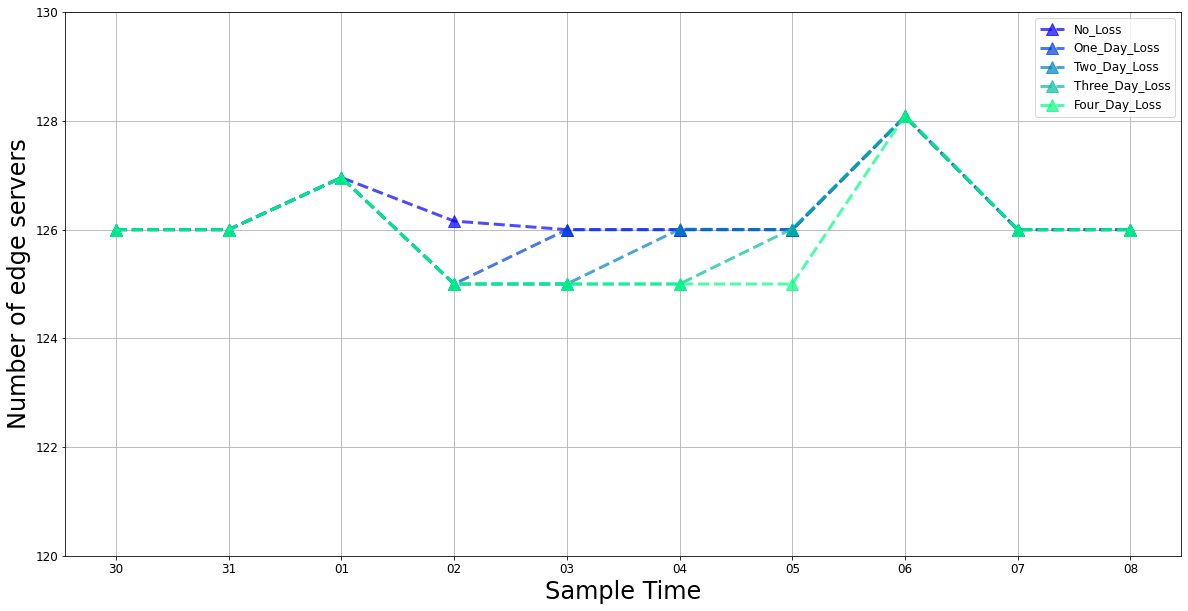

In [53]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['30', '31', '01', '02', '03', '04', '05', '06', '07', '08']
color_idx = np.linspace(0, 1, 5)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
ax.set_ylim(bottom = 120, top = 130)
# plt.plot(x_axis, BS_24hr_12am[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)


plt.plot(x_axis, estimate_N_24hr_12pm_1hr[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='No_Loss', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr_1day[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='One_Day_Loss', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr_2days[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='Two_Day_Loss', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr_3days[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[3]), label='Three_Day_Loss', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr_4days[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[4]), label='Four_Day_Loss', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [11]:
def get_server_ip_sampling(date, t1, t2, idx, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((idx,), dtype = int)
    marked_sum = 0
    if idx > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[idx, :idx] = last_rec[::-1]
        
    m_t[idx] = marked_sum
    u_t[idx] = len(C)-marked_sum
    n_t[idx] = len(C)
    record_server_table.append(C)
    C_tran[idx] = C_t

CJS model -- 48hr -- 1day/12am

In [398]:
C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 0:
        get_server_ip_sampling(d, "00:00:00", "01:00:00", j//2, 'west-us')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 0:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 0:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_firstday_12am_1hr_us = N_t
C_tran_48hr_firstday_12am_1hr_us = C_tran
print(estimate_N_48hr_firstday_12am_1hr_us)
print(np.mean(np.abs(estimate_N_48hr_firstday_12am_1hr_us[1:-1] - BS_24hr_12am_us_1day[2:-2:2]) / BS_24hr_12am_us_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_firstday_12am_1hr_us[1:-1] - BS_24hr_12am_us_2day[1:-1]) / BS_24hr_12am_us_2day[1:-1]))


C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 0:
        get_server_ip_sampling(d, "00:00:00", "01:00:00", j//2, 'west-eu')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 0:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 0:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_firstday_12am_1hr_eu = N_t
C_tran_48hr_firstday_12am_1hr_eu = C_tran
print(estimate_N_48hr_firstday_12am_1hr_eu)
print(np.mean(np.abs(estimate_N_48hr_firstday_12am_1hr_eu[1:-1] - BS_24hr_12am_eu_1day[2:-2:2]) / BS_24hr_12am_eu_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_firstday_12am_1hr_eu[1:-1] - BS_24hr_12am_eu_2day[1:-1]) / BS_24hr_12am_eu_2day[1:-1]))


[  0.          93.84        95.58461538 106.35882353  50.
  50.           0.        ]
0.43165241783552205
0.4568729819594884
[  0.         147.10820758 191.79455877 215.91551499 167.64878981
  52.           0.        ]
0.7480322829446998
0.7633298212364896


CJS model -- 48hr -- 1day/12pm

In [397]:
C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 0:
        get_server_ip_sampling(d, "12:00:00", "13:00:00", j//2, 'west-us')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 0:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 0:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_firstday_12pm_1hr_us = N_t
C_tran_48hr_firstday_12pm_1hr_us = C_tran
print(estimate_N_48hr_firstday_12pm_1hr_us)
print(np.mean(np.abs(estimate_N_48hr_firstday_12pm_1hr_us[1:-1] - BS_24hr_12am_us_1day[2:-2:2]) / BS_24hr_12am_us_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_firstday_12pm_1hr_us[1:-1] - BS_24hr_12am_us_2day[1:-1]) / BS_24hr_12am_us_2day[1:-1]))


C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 0:
        get_server_ip_sampling(d, "12:00:00", "13:00:00", j//2, 'west-eu')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 0:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 0:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_firstday_12pm_1hr_eu = N_t
C_tran_48hr_firstday_12pm_1hr_eu = C_tran
print(estimate_N_48hr_firstday_12pm_1hr_eu)
print(np.mean(np.abs(estimate_N_48hr_firstday_12pm_1hr_eu[1:-1] - BS_24hr_12am_eu_1day[2:-2:2]) / BS_24hr_12am_eu_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_firstday_12pm_1hr_eu[1:-1] - BS_24hr_12am_eu_2day[1:-1]) / BS_24hr_12am_eu_2day[1:-1]))


[  0.          76.93150685  89.54117647 126.         126.
 126.          99.        ]
0.21287408315190573
0.25546622855445633
[  0.         380.27149321 341.7851347  536.56422569 463.76289295
 482.90272928 107.        ]
0.28376630178708545
0.32887271677834773


CJS model -- 48hr -- 2day/12am

In [396]:
C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 1:
        get_server_ip_sampling(d, "00:00:00", "01:00:00", j//2, 'west-us')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 1:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 1:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_secondday_12am_1hr_us = N_t
C_tran_48hr_secondday_12am_1hr_us = C_tran
print(estimate_N_48hr_secondday_12am_1hr_us)
print(np.mean(np.abs(estimate_N_48hr_secondday_12am_1hr_us[1:-1] - BS_24hr_12am_us_1day[2:-2:2]) / BS_24hr_12am_us_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_secondday_12am_1hr_us[1:-1] - BS_24hr_12am_us_2day[1:-1]) / BS_24hr_12am_us_2day[1:-1]))


C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 1:
        get_server_ip_sampling(d, "00:00:00", "01:00:00", j//2, 'west-eu')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 1:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 1:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_secondday_12am_1hr_eu = N_t
C_tran_48hr_secondday_12am_1hr_eu = C_tran
print(estimate_N_48hr_secondday_12am_1hr_eu)
print(np.mean(np.abs(estimate_N_48hr_secondday_12am_1hr_eu[1:-1] - BS_24hr_12am_eu_1day[2:-2:2]) / BS_24hr_12am_eu_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_secondday_12am_1hr_eu[1:-1] - BS_24hr_12am_eu_2day[1:-1]) / BS_24hr_12am_eu_2day[1:-1]))


[ 0.         59.29719339 58.         65.3362069  50.         50.
 50.        ]
0.5916781655004557
0.6117984613617292
[  0.         152.81132075 179.87596774 239.91898148 271.51576837
 178.21994048 132.83478261]
0.669212924459304
0.6896187259624187


CJS model -- 48hr -- 2day/12pm

In [395]:
C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 1:
        get_server_ip_sampling(d, "12:00:00", "13:00:00", j//2, 'west-us')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 1:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 1:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_secondday_12pm_1hr_us = N_t
C_tran_48hr_secondday_12pm_1hr_us = C_tran
print(estimate_N_48hr_secondday_12pm_1hr_us)
print(np.mean(np.abs(estimate_N_48hr_secondday_12pm_1hr_us[1:-1] - BS_24hr_12am_us_1day[2:-2:2]) / BS_24hr_12am_us_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_secondday_12pm_1hr_us[1:-1] - BS_24hr_12am_us_2day[1:-1]) / BS_24hr_12am_us_2day[1:-1]))


C_tran = np.zeros((len(date)//2,), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date)//2, len(date)//2), dtype = int)
m_t, u_t, n_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    if j % 2 == 1:
        get_server_ip_sampling(d, "12:00:00", "13:00:00", j//2, 'west-eu')

R_t, Z_t = np.zeros((len(date)//2,), dtype = int), np.zeros((len(date)//2,), dtype = int)    
for d, _ in enumerate(date):
    if d % 2 == 1:
        R_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, d//2])

for d in range(len(date)):
    if d % 2 == 1:
        Z_t[d//2] = np.sum(last_capture_table[(d//2+1):len(date)//2, :d//2])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_48hr_secondday_12pm_1hr_eu = N_t
C_tran_48hr_secondday_12pm_1hr_eu = C_tran
print(estimate_N_48hr_secondday_12pm_1hr_eu)
print(np.mean(np.abs(estimate_N_48hr_secondday_12pm_1hr_eu[1:-1] - BS_24hr_12am_eu_1day[2:-2:2]) / BS_24hr_12am_eu_1day[2:-2:2]))
print(np.mean(np.abs(estimate_N_48hr_secondday_12pm_1hr_eu[1:-1] - BS_24hr_12am_eu_2day[1:-1]) / BS_24hr_12am_eu_2day[1:-1]))


[  0.         125.99206349 126.15740741 126.         128.0814256
 126.         104.        ]
0.08306108859395275
0.13020619444014625
[  0.         319.2939583  532.14285714 753.70159981 462.68758683
 422.14453985 318.99371069]
0.2381547538019614
0.27852991152995016


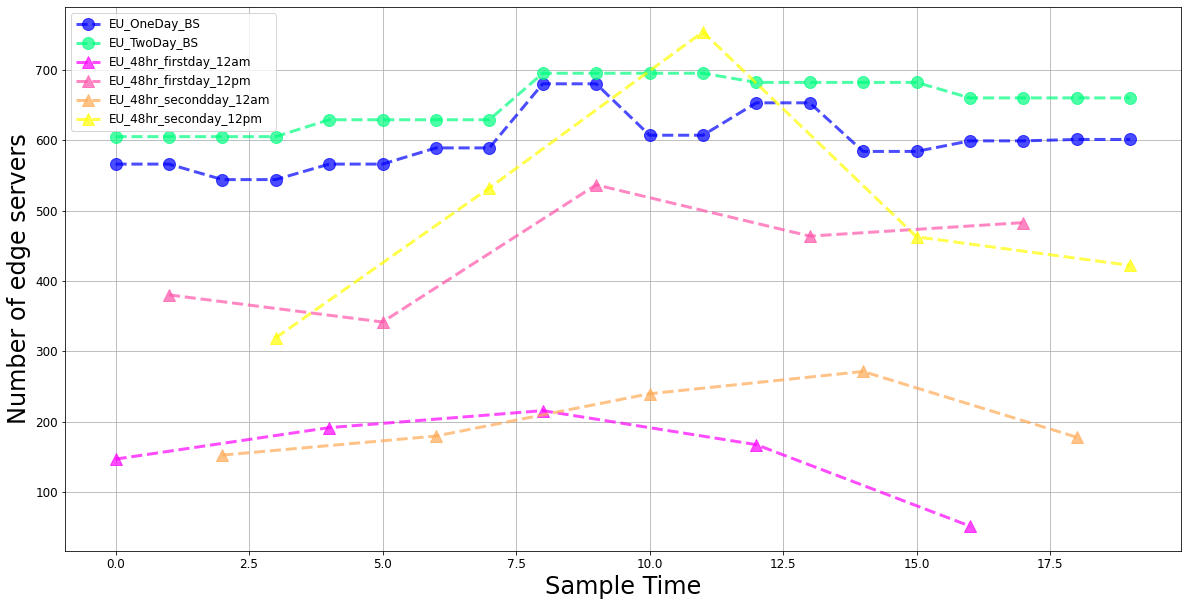

In [394]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [d for d in range(20)]
x_axis1 = [4*d for d in range(5)]
x_axis2 = [4*d+1 for d in range(5)]
x_axis3 = [4*d+2 for d in range(5)]
x_axis4 = [4*d+3 for d in range(5)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_1day[2:-2], 2), "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='EU_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_2day[1:-1], 4), "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[3]), label='EU_TwoDay_BS', alpha=0.7)

plt.plot(x_axis1, estimate_N_48hr_firstday_12am_1hr_eu[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_48hr_firstday_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_48hr_firstday_12pm_1hr_eu[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='EU_48hr_firstday_12pm', alpha=0.7)
plt.plot(x_axis3, estimate_N_48hr_secondday_12am_1hr_eu[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='EU_48hr_secondday_12am', alpha=0.7)
plt.plot(x_axis4, estimate_N_48hr_secondday_12pm_1hr_eu[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='EU_48hr_seconday_12pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

CJS model -- 24 hr -- 12am

In [12]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am_1hr_us = N_t
C_tran_24hr_12am_1hr_us = C_tran
print(estimate_N_24hr_12am_1hr_us)
print(np.mean(np.abs(estimate_N_24hr_12am_1hr_us[2:-2] - BS_24hr_12am_us_1day[2:-2]) / BS_24hr_12am_us_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_12am_1hr_us[2:-2] - BS_repeat_2day) / BS_repeat_2day))


C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", j, 'west-eu')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am_1hr_eu = N_t
C_tran_24hr_12am_1hr_eu = C_tran
print(estimate_N_24hr_12am_1hr_eu)
print(np.mean(np.abs(estimate_N_24hr_12am_1hr_eu[2:-2] - BS_24hr_12am_eu_1day[2:-2]) / BS_24hr_12am_eu_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_12am_1hr_eu[2:-2] - BS_repeat_2day) / BS_repeat_2day))

[  0.         126.79054054 108.         111.27720108 112.43076923
 100.         113.4765625   65.3046875   50.          50.
  50.          50.          50.          50.        ]
0.4055032447571253
0.44048227734645595
[  0.         110.32258065 176.03703704 180.8902439  183.76068376
 183.25301205 215.51191809 263.35983936 203.9084507  277.14825786
 156.87234043 179.8653169  116.         132.85470085]
0.6621869824357351
0.6921955533549041


CJS model -- 24 hr -- 4am

In [13]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4am_1hr_us = N_t
C_tran_24hr_4am_1hr_us = C_tran
print(estimate_N_24hr_4am_1hr_us)
print(np.mean(np.abs(estimate_N_24hr_4am_1hr_us[2:-2] - BS_24hr_12am_us_1day[2:-2]) / BS_24hr_12am_us_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_4am_1hr_us[2:-2] - BS_repeat_2day) / BS_repeat_2day))


C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", j, 'west-eu')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4am_1hr_eu = N_t
C_tran_24hr_4am_1hr_eu = C_tran
print(estimate_N_24hr_4am_1hr_eu)
print(np.mean(np.abs(estimate_N_24hr_4am_1hr_eu[2:-2] - BS_24hr_12am_eu_1day[2:-2]) / BS_24hr_12am_eu_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_4am_1hr_eu[2:-2] - BS_repeat_2day) / BS_repeat_2day))


[ 0.         75.34901961 78.23076923 74.         74.         85.67444444
 77.         78.71377368 78.00999616 76.         76.         76.
 89.81818182 57.        ]
0.4314066727567015
0.4678781373471148
[  0.         214.27523325 626.84931507 421.03400622 373.24726836
 371.         611.07613961 399.         456.82134266 344.87534626
 319.55207522 782.85714286 197.05263158 236.27536232]
0.2967248668827561
0.3230089661181422


CJS model -- 24 hr -- 8am

In [14]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "08:00:00", "09:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8am_1hr_us = N_t
C_tran_24hr_8am_1hr_us = C_tran
print(estimate_N_24hr_8am_1hr_us)
print(np.mean(np.abs(estimate_N_24hr_8am_1hr_us[2:-2] - BS_24hr_12am_us_1day[2:-2]) / BS_24hr_12am_us_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_8am_1hr_us[2:-2] - BS_repeat_2day) / BS_repeat_2day))


C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "08:00:00", "09:00:00", j, 'west-eu')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8am_1hr_eu = N_t
C_tran_24hr_8am_1hr_eu = C_tran
print(estimate_N_24hr_8am_1hr_eu)
print(np.mean(np.abs(estimate_N_24hr_8am_1hr_eu[2:-2] - BS_24hr_12am_eu_1day[2:-2]) / BS_24hr_12am_eu_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_8am_1hr_eu[2:-2] - BS_repeat_2day) / BS_repeat_2day))


[  0.          74.46       121.02748126 119.         123.10344828
 128.48209524 127.947404   126.         126.         126.
 126.54545455 122.37755102 108.47368421 103.        ]
0.08572260464694928
0.14306814588094258
[  0.         345.40191105 345.59550562 344.         346.81967213
 346.         347.40650407 364.63829787 358.568925   358.39043825
 470.1471976  394.14563107 427.08333333 374.78709677]
0.3841752797511188
0.4373391052960807


CJS model -- 24 hr -- 12pm

In [15]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "13:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr_us = N_t
C_tran_24hr_12pm_1hr_us = C_tran
print(estimate_N_24hr_12pm_1hr_us)
print(np.mean(np.abs(estimate_N_24hr_12pm_1hr_us[2:-2] - BS_24hr_12am_us_1day[2:-2]) / BS_24hr_12am_us_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_12pm_1hr_us[2:-2] - BS_repeat_2day) / BS_repeat_2day))


C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "13:00:00", j, 'west-eu')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr_eu = N_t
C_tran_24hr_12pm_1hr_eu = C_tran
print(estimate_N_24hr_12pm_1hr_eu)
print(np.mean(np.abs(estimate_N_24hr_12pm_1hr_eu[2:-2] - BS_24hr_12am_eu_1day[2:-2]) / BS_24hr_12am_eu_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_12pm_1hr_eu[2:-2] - BS_repeat_2day) / BS_repeat_2day))


[  0.         126.         126.         126.         126.95861592
 126.15740741 126.         126.         126.         128.0814256
 126.         126.         116.97752809 104.        ]
0.07250395067041507
0.13092327184062208
[  0.         385.88957055 404.88198616 397.06110289 394.
 578.07534621 570.45977607 650.39852042 492.         498.07409354
 502.55073221 421.38461538 328.14285714 319.        ]
0.1963354877413908
0.25207902007478145


CJS model -- 24 hr -- 4pm

In [16]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "16:00:00", "17:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4pm_1hr_us = N_t
C_tran_24hr_4pm_1hr_us = C_tran
print(estimate_N_24hr_4pm_1hr_us)
print(np.mean(np.abs(estimate_N_24hr_4pm_1hr_us[2:-2] - BS_24hr_12am_us_1day[2:-2]) / BS_24hr_12am_us_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_4pm_1hr_us[2:-2] - BS_repeat_2day) / BS_repeat_2day))


C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "16:00:00", "17:00:00", j, 'west-eu')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4pm_1hr_eu = N_t
C_tran_24hr_4pm_1hr_eu = C_tran
print(estimate_N_24hr_4pm_1hr_eu)
print(np.mean(np.abs(estimate_N_24hr_4pm_1hr_eu[2:-2] - BS_24hr_12am_eu_1day[2:-2]) / BS_24hr_12am_eu_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_4pm_1hr_eu[2:-2] - BS_repeat_2day) / BS_repeat_2day))


[  0.         130.47761194 124.95867769 124.         127.91080354
 124.         126.4685571  127.95181406 124.         127.91080354
 124.44186047 126.87120338 124.24195122 100.        ]
0.07613634111426108
0.1343126130752448
[  0.         175.92727273 176.         296.09411765 305.19774011
 301.81818182 496.34327559 377.56401655 531.74775801 486.05362377
 482.23177135 369.46153846 357.42524806 288.99653979]
0.3674774073395543
0.42143876182574297


CJS model -- 24 hr -- 8pm

In [17]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "20:00:00", "21:00:00", j, 'west-us')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8pm_1hr_us = N_t
C_tran_24hr_8pm_1hr_us = C_tran
print(estimate_N_24hr_8pm_1hr_us)
print(np.mean(np.abs(estimate_N_24hr_8pm_1hr_us[2:-2] - BS_24hr_12am_us_1day[2:-2]) / BS_24hr_12am_us_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_8pm_1hr_us[2:-2] - BS_repeat_2day) / BS_repeat_2day))


C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "20:00:00", "21:00:00", j, 'west-eu')

R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8pm_1hr_eu = N_t
C_tran_24hr_8pm_1hr_eu = C_tran
print(estimate_N_24hr_8pm_1hr_eu)
print(np.mean(np.abs(estimate_N_24hr_8pm_1hr_eu[2:-2] - BS_24hr_12am_eu_1day[2:-2]) / BS_24hr_12am_eu_1day[2:-2]))
BS_repeat_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 2)
print(np.mean(np.abs(estimate_N_24hr_8pm_1hr_eu[2:-2] - BS_repeat_2day) / BS_repeat_2day))


[  0.          69.36        69.          69.          69.
 124.2        109.2745098   73.          73.          73.
  73.          73.          74.97297297  50.        ]
0.4089554847870251
0.44729075775215543
[  0.         169.         169.         169.         186.3630137
 184.         372.55272065 533.08636957 247.         339.34273859
 263.         263.         264.44886364 178.        ]
0.5487001954065777
0.5892722281102419


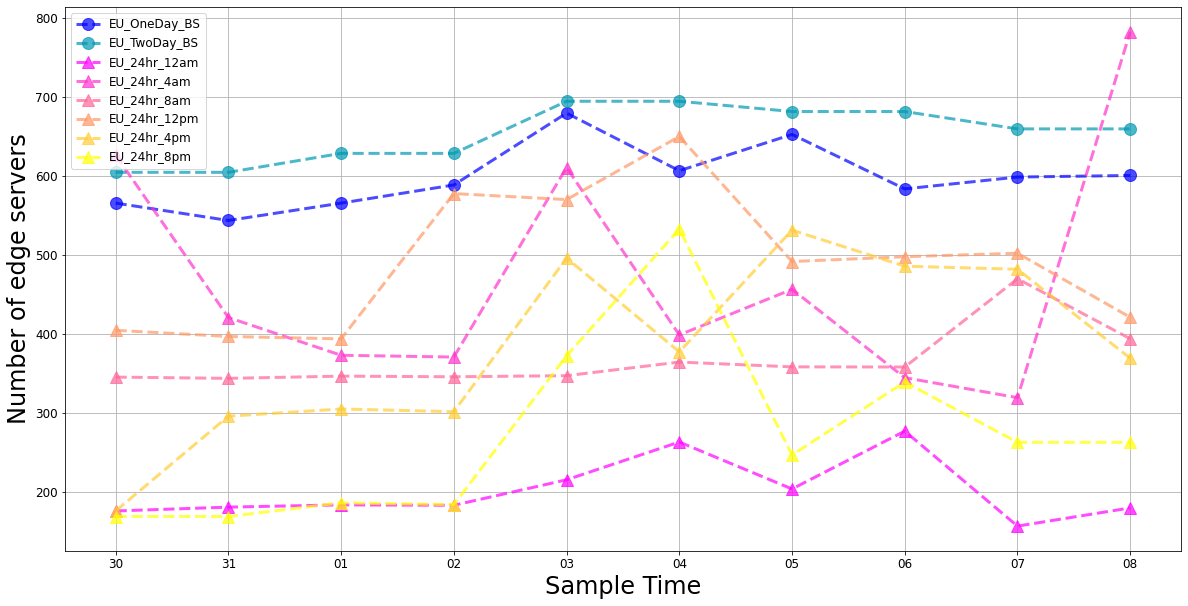

In [20]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['30', '31', '01', '02', '03', '04', '05', '06', '07', '08']
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis, BS_24hr_12am_eu_1day[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='EU_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_2day[1:-1], 2), "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[3]), label='EU_TwoDay_BS', alpha=0.7)

plt.plot(x_axis, estimate_N_24hr_12am_1hr_eu[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_24hr_12am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_4am_1hr_eu[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='EU_24hr_4am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_8am_1hr_eu[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='EU_24hr_8am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr_eu[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='EU_24hr_12pm', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_4pm_1hr_eu[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='EU_24hr_4pm', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_8pm_1hr_eu[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='EU_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

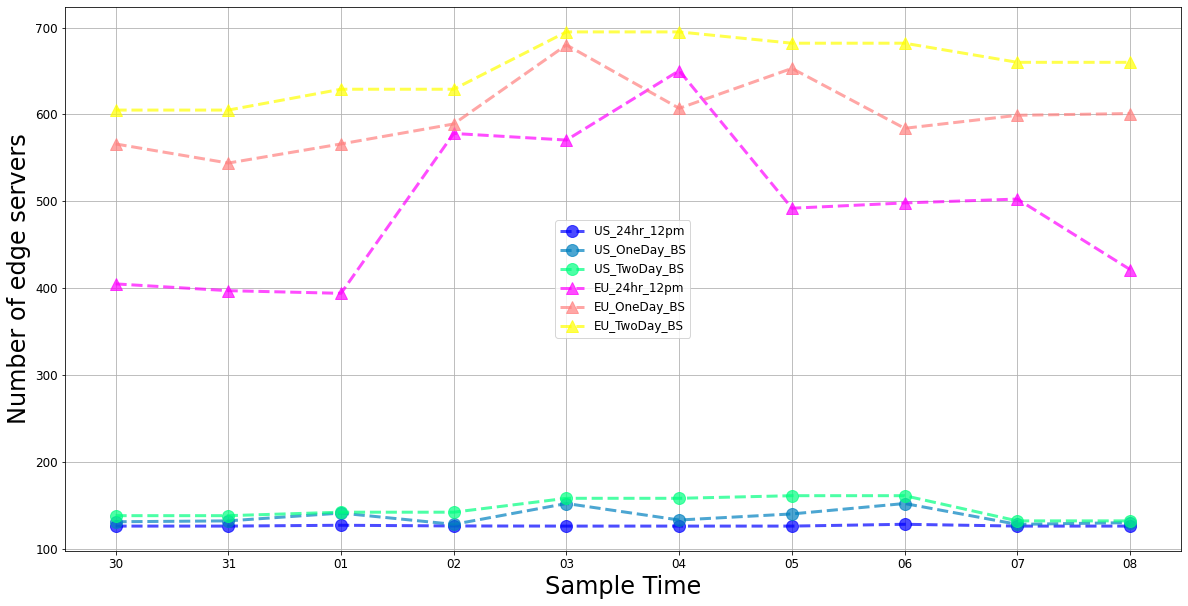

In [21]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['30', '31', '01', '02', '03', '04', '05', '06', '07', '08']
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr_us[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='US_24hr_12pm', alpha=0.7)
plt.plot(x_axis, BS_24hr_12am_us_1day[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='US_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_us_2day[1:-1], 2), "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='US_TwoDay_BS', alpha=0.7)

plt.plot(x_axis, estimate_N_24hr_12pm_1hr_eu[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_24hr_12pm', alpha=0.7)
plt.plot(x_axis, BS_24hr_12am_eu_1day[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='EU_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_2day[1:-1], 2), "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='EU_TwoDay_BS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

CJS model -- 8 hr -- 12am

In [316]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_1hr_us = N_t
C_tran_8hr_12am_1hr_us = C_tran
print(estimate_N_8hr_12am_1hr_us)
BS_repeat3_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_12am_1hr_us[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_12am_1hr_us[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))


C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 3*j, 'west-eu')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 3*j+1, 'west-eu')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 3*j+2, 'west-eu')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_1hr_eu = N_t
C_tran_8hr_12am_1hr_eu = C_tran
print(estimate_N_8hr_12am_1hr_eu)
BS_repeat3_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_12am_1hr_eu[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_12am_1hr_eu[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))


[  0.         103.39726027 112.47126437 125.4375     119.
 125.76136364 124.         128.37836673 126.         129.99000384
 126.         126.         126.         126.         129.99000384
 126.         127.2        127.         127.         128.97079502
 129.55246914 128.984375   128.         130.56582633 127.
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 128.49019608 126.         127.13559322 125.11965812 118.
 121.13953488 100.        ]
0.06347418109501535
0.1229238170071573
[  0.         272.82051282 319.6875     337.5        354.60431655
 351.98863636 351.         352.29044118 352.         359.91011236
 354.         493.87317073 438.50806452 436.         436.
 436.         436.         436.         441.77483444 439.7804878
 610.03722122 506.66666667 494.07265118 504.         496.
 499.972425   539.63071186 493.75842697 492.         505.48529742
 489.         492.31579933 487.         493.76388889 494.255

CJS model -- 8 hr -- 2am

In [317]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_1hr_us = N_t
C_tran_8hr_2am_1hr_us = C_tran
print(estimate_N_8hr_2am_1hr_us)
BS_repeat3_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_2am_1hr_us[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_2am_1hr_us[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))


C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 3*j, 'west-eu')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 3*j+1, 'west-eu')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 3*j+2, 'west-eu')


R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_1hr_eu = N_t
C_tran_8hr_2am_1hr_eu = C_tran
print(estimate_N_8hr_2am_1hr_eu)
BS_repeat3_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_2am_1hr_eu[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_2am_1hr_eu[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))

[  0.          66.64        71.92647059 115.32427184 110.
 124.51417365 118.         123.31531532 126.36986301 125.
 125.         125.         125.         125.         125.
 125.         127.03252033 128.29591837 128.         128.
 128.         128.         128.         130.48543689 130.
 130.         140.96333573 127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.016
 128.9047619   65.        ]
0.07027445602244614
0.12642921600166704
[  0.         313.76086957 344.39520958 324.         324.
 464.0516129  599.9375     443.63700159 445.81967213 443.
 446.03424658 445.         590.375885   465.65714286 465.
 467.55494505 477.69175627 497.59876754 471.         473.44041451
 486.30294014 476.2464455  478.03514377 477.         477.
 477.         477.         477.         477.29972752 476.
 476.         515.48897777 464.         464.         474.07210031
 437.         438.81935484 493.41030765 326

CJS model -- 8 hr -- 4am

In [318]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_1hr_us = N_t
C_tran_8hr_4am_1hr_us = C_tran
print(estimate_N_8hr_4am_1hr_us)
BS_repeat3_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_4am_1hr_us[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_4am_1hr_us[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))


C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 3*j, 'west-eu')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 3*j+1, 'west-eu')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 3*j+2, 'west-eu')


R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_1hr_eu = N_t
C_tran_8hr_4am_1hr_eu = C_tran
print(estimate_N_8hr_4am_1hr_eu)
BS_repeat3_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_4am_1hr_eu[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_4am_1hr_eu[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))

[  0.          72.98630137 100.74        95.68       126.
 126.         126.         126.         126.         126.
 126.         125.         125.         126.95861592 125.
 126.52439024 126.         126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.0814256  126.
 126.         126.         126.         126.         126.
 119.         120.33333333 116.97752809 105.792      104.
 104.          50.        ]
0.08523023851628266
0.13387557267796169
[  0.         375.46261181 377.1875     500.93103448 421.27717391
 420.         420.         468.13965955 453.         466.21103842
 463.90996877 460.         460.         460.         460.
 460.         576.02552817 516.         600.75362319 560.54794521
 600.72950597 562.         627.10328824 507.         509.69399008
 507.         507.         507.         507.         509.06688963
 505.69852941 509.76470588 456.         561.04347826 432.69172932
 376. 

CJS model -- 8 hr -- 6am

In [384]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_1hr_us = N_t
C_tran_8hr_6am_1hr_us = C_tran
print(estimate_N_8hr_6am_1hr_us)
BS_repeat3_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_6am_1hr_us[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_6am_1hr_us[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))


C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 3*j, 'west-eu')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 3*j+1, 'west-eu')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 3*j+2, 'west-eu')


R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_1hr_eu = N_t
C_tran_8hr_6am_1hr_eu = C_tran
print(estimate_N_8hr_6am_1hr_eu)
BS_repeat3_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 3)
print(np.mean(np.abs(estimate_N_8hr_6am_1hr_eu[3:-3] - BS_repeat3_1day) / BS_repeat3_1day))
BS_repeat3_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 6)
print(np.mean(np.abs(estimate_N_8hr_6am_1hr_eu[6:-6] - BS_repeat3_2day) / BS_repeat3_2day))

[  0.          49.98       122.5        125.46       124.
 126.2962963  126.76056338 126.         126.         126.
 126.         126.         126.         126.         126.
 127.44827586 127.         127.         127.         127.
 127.         127.         128.3956044  128.         128.
 128.         128.         128.         139.37245179 127.
 127.         127.         127.         127.         127.
 127.         128.2275158  125.         125.32978723 124.
 125.27030844 122.        ]
0.06325051075781271
0.12409049563310302
[  0.         310.74193548 309.77777778 450.98110719 396.27586207
 382.         386.01165749 517.05       488.         488.
 488.         488.         529.7721895  497.         497.
 505.64740862 572.         535.         574.6797691  580.76951939
 568.20731707 719.23361851 600.18613139 598.         722.02225856
 597.47754742 530.         530.         544.41871807 518.
 537.54372281 508.         509.01587302 562.82003995 484.33333333
 415.         421.92608696 409

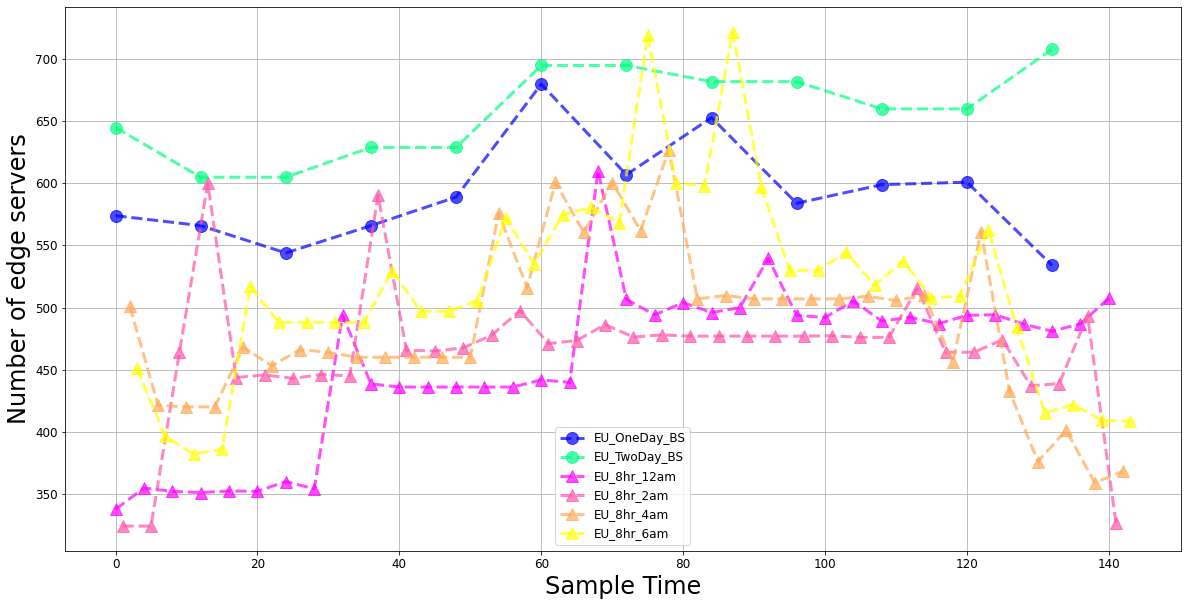

In [386]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [12*d for d in range(12)]
x_axis1 = [4*d for d in range(12*3)]
x_axis2 = [4*d+1 for d in range(12*3)]
x_axis3 = [4*d+2 for d in range(12*3)]
x_axis4 = [4*d+3 for d in range(12*3)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am_eu_1day[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='EU_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_2day, 2)[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[3]), label='EU_TwoDay_BS', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am_1hr_eu[3:-3], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_8hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_2am_1hr_eu[3:-3], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='EU_8hr_2am', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_4am_1hr_eu[3:-3], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='EU_8hr_4am', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_6am_1hr_eu[3:-3], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='EU_8hr_6am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

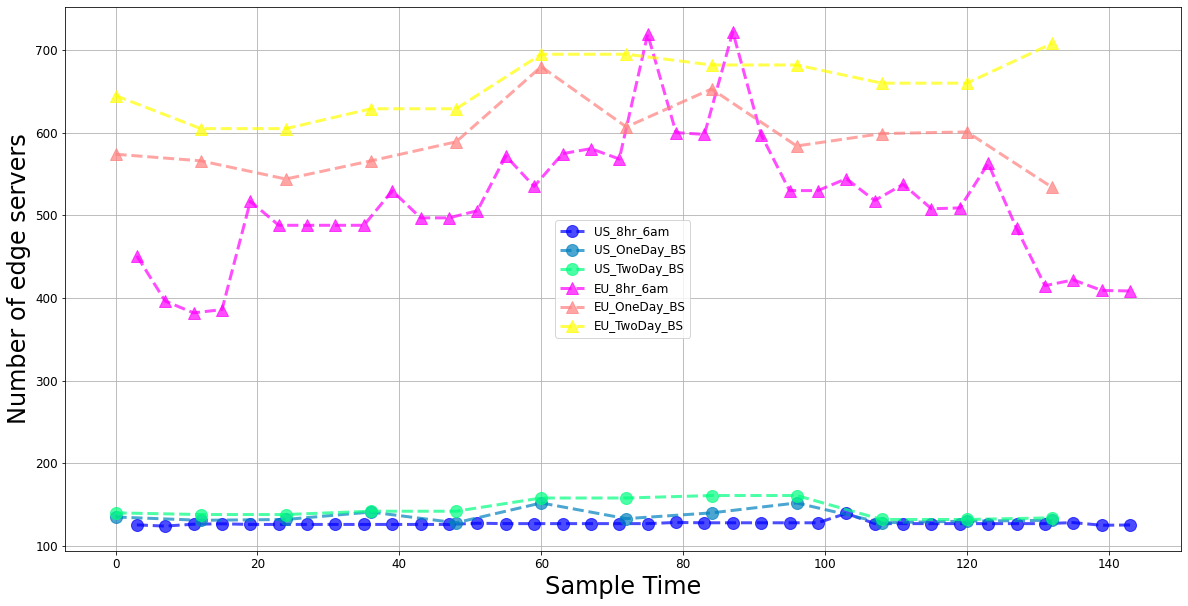

In [387]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [12*d for d in range(12)]
x_axis4 = [4*d+3 for d in range(12*3)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis4, estimate_N_8hr_6am_1hr_us[3:-3], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='US_8hr_6am', alpha=0.7)
plt.plot(x_axis, BS_24hr_12am_us_1day[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='US_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_us_2day, 2)[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='US_TwoDay_BS', alpha=0.7)

plt.plot(x_axis4, estimate_N_8hr_6am_1hr_eu[3:-3], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_8hr_6am', alpha=0.7)
plt.plot(x_axis, BS_24hr_12am_eu_1day[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='EU_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_2day, 2)[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='EU_TwoDay_BS', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

CJS model -- 4 hr -- 12am

In [22]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_1hr_us = N_t
C_tran_4hr_12am_1hr_us = C_tran
print(estimate_N_4hr_12am_1hr_us)
BS_repeat6_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_12am_1hr_us[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_12am_1hr_us[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))


C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 6*j, 'west-eu')
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 6*j+1, 'west-eu')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 6*j+2, 'west-eu')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 6*j+3, 'west-eu')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 6*j+4, 'west-eu')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 6*j+5, 'west-eu')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_1hr_eu = N_t
C_tran_4hr_12am_1hr_eu = C_tran
print(estimate_N_4hr_12am_1hr_eu)
BS_repeat6_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_12am_1hr_eu[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_12am_1hr_eu[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))

[  0.         103.81384875 103.39726027 104.4109589  113.56321839
 124.64516129 129.1275     124.         124.         127.02439024
 127.         127.         127.         127.         129.21071429
 128.         128.         128.         132.06920415 128.
 128.         128.01587302 127.         127.         127.
 127.         127.         128.49411765 132.06920415 128.
 128.         129.56097561 130.22857143 130.         130.
 130.         130.         130.         130.51162791 129.
 131.60841049 129.         131.015625   130.         130.
 130.         131.07142857 128.         128.         132.06920415
 128.         128.         128.         128.         128.
 128.         128.         129.08903226 131.029604   127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.         127.13559322
 125.         125.01626016 126.32888889 124.         124.
 124.84       123.76470588 100. 

CJS model -- 4 hr -- 1am

In [23]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "02:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "06:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "10:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "14:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "18:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "22:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_1hr_us = N_t
C_tran_4hr_1am_1hr_us = C_tran
print(estimate_N_4hr_1am_1hr_us)
BS_repeat6_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_1am_1hr_us[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_1am_1hr_us[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))


C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "02:00:00", 6*j, 'west-eu')
    get_server_ip_sampling(d, "05:00:00", "06:00:00", 6*j+1, 'west-eu')
    get_server_ip_sampling(d, "09:00:00", "10:00:00", 6*j+2, 'west-eu')
    get_server_ip_sampling(d, "13:00:00", "14:00:00", 6*j+3, 'west-eu')
    get_server_ip_sampling(d, "17:00:00", "18:00:00", 6*j+4, 'west-eu')
    get_server_ip_sampling(d, "21:00:00", "22:00:00", 6*j+5, 'west-eu')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_1hr_eu = N_t
C_tran_4hr_1am_1hr_eu = C_tran
print(estimate_N_4hr_1am_1hr_eu)
BS_repeat6_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_1am_1hr_eu[6:-6] - BS_repeat6_1day)))
print(np.mean(np.abs(estimate_N_4hr_1am_1hr_eu[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_1am_1hr_eu[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))

[  0.          49.          75.46       123.37662338 124.
 124.         125.96825397 128.95040369 125.         128.07336585
 127.         127.         127.         129.49019608 128.
 129.04918033 130.51710812 129.         129.         129.
 129.         129.         129.         131.48076923 130.
 130.         130.         132.10348706 133.56862745 141.85810811
 131.         132.48863636 132.         132.         132.
 132.         132.         132.         132.         132.
 132.         132.         132.         132.         132.
 133.67088608 133.         133.         133.         133.51136364
 136.22760477 132.         132.         132.         133.58823529
 131.         163.18417367 126.         126.         126.
 126.         126.         126.         126.         127.26012436
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         129.7752809  112.         112.         112.
 113.45       109.56230159  70. 

CJS model -- 4 hr -- 2am

In [24]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_1hr_us = N_t
C_tran_4hr_2am_1hr_us = C_tran
print(estimate_N_4hr_2am_1hr_us)
BS_repeat6_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_2am_1hr_us[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_2am_1hr_us[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))


C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 6*j, 'west-eu')
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 6*j+1, 'west-eu')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 6*j+2, 'west-eu')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 6*j+3, 'west-eu')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 6*j+4, 'west-eu')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 6*j+5, 'west-eu')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_1hr_eu = N_t
C_tran_4hr_2am_1hr_eu = C_tran
print(estimate_N_4hr_2am_1hr_eu)
BS_repeat6_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_2am_1hr_eu[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_2am_1hr_eu[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))

[  0.          49.          66.64        68.34        73.
 126.7641129  127.68855892 126.         126.         126.
 128.21022272 128.33333333 127.         127.         127.
 127.         128.71621622 128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         129.47126437 129.         129.         130.31632653
 130.         130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.42857143 133.54368932 133.         133.         133.
 133.         133.         140.81145503 131.         131.
 131.         131.         141.64822404 129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.13333333 127.
 127.         127.         127.         127.016      126.
 126.04918033 125.27030844 122.         122.        ]
0.04950173

CJS model -- 4 hr -- 3am

In [25]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "04:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "08:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "12:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "16:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "20:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:59:59", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_1hr_us = N_t
C_tran_4hr_3am_1hr_us = C_tran
print(estimate_N_4hr_3am_1hr_us)
BS_repeat6_1day = np.repeat(BS_24hr_12am_us_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_3am_1hr_us[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_us_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_3am_1hr_us[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))


C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "04:00:00", 6*j, 'west-eu')
    get_server_ip_sampling(d, "07:00:00", "08:00:00", 6*j+1, 'west-eu')
    get_server_ip_sampling(d, "11:00:00", "12:00:00", 6*j+2, 'west-eu')
    get_server_ip_sampling(d, "15:00:00", "16:00:00", 6*j+3, 'west-eu')
    get_server_ip_sampling(d, "19:00:00", "20:00:00", 6*j+4, 'west-eu')
    get_server_ip_sampling(d, "23:00:00", "23:59:59", 6*j+5, 'west-eu')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_1hr_eu = N_t
C_tran_4hr_3am_1hr_eu = C_tran
print(estimate_N_4hr_3am_1hr_eu)
BS_repeat6_1day = np.repeat(BS_24hr_12am_eu_1day[1:-1], 6)
print(np.mean(np.abs(estimate_N_4hr_3am_1hr_eu[6:-6] - BS_repeat6_1day) / BS_repeat6_1day))
BS_repeat6_2day = np.repeat(BS_24hr_12am_eu_2day[1:-1], 12)
print(np.mean(np.abs(estimate_N_4hr_3am_1hr_eu[12:-12] - BS_repeat6_2day) / BS_repeat6_2day))

[  0.         100.8         92.          93.84        97.89473684
 110.66666667 113.42       126.5        122.         131.07476729
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         131.70202762
 130.74324324 130.         132.54901961 131.         132.56862745
 131.54901961 131.5586414  129.         129.         129.
 129.         130.69736842 130.         130.         130.
 130.         130.         130.         152.58530184 131.
 132.53322072 130.         130.         130.         131.25111474
 131.54901961 129.         129.         129.         129.
 129.         129.         129.         134.59841629 128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 132.06920415 128.         128.         129.12451335 129.50980392
 127.         127.         127.         127.11403509 128.38257778
 126.         126.         126.1559633  125.         125.10619469
 124.   

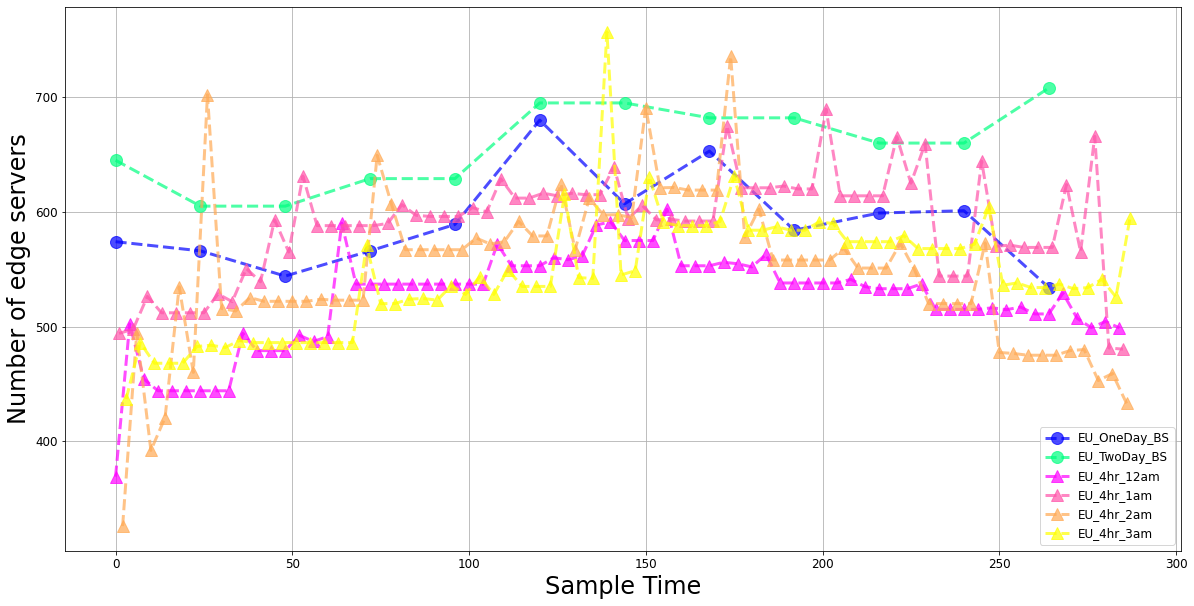

In [26]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [24*d for d in range(12)]
x_axis1 = [4*d for d in range(12*6)]
x_axis2 = [4*d+1 for d in range(12*6)]
x_axis3 = [4*d+2 for d in range(12*6)]
x_axis4 = [4*d+3 for d in range(12*6)]

color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am_eu_1day[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='EU_OneDay_BS', alpha=0.7)
plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_2day, 2)[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[3]), label='EU_TwoDay_BS', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am_1hr_eu[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_4hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_1am_1hr_eu[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='EU_4hr_1am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_2am_1hr_eu[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='EU_4hr_2am', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_3am_1hr_eu[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='EU_4hr_3am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

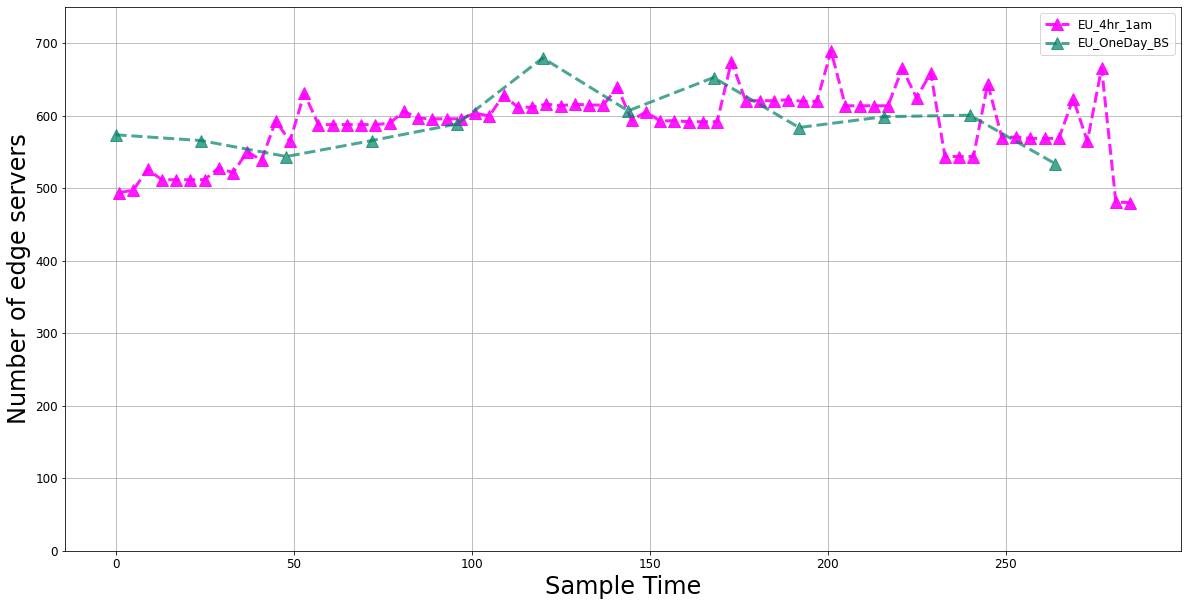

In [27]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [24*d for d in range(12)]
x_axis1 = [4*d+1 for d in range(12*6)]
color_idx = np.linspace(0, 1, 2)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

# plt.plot(x_axis1, estimate_N_4hr_1am_1hr_us[6:-6], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='US_4hr_1am', alpha=0.7)
# plt.plot(x_axis, BS_24hr_12am_us_1day[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='US_OneDay_BS', alpha=0.7)
# plt.plot(x_axis, np.repeat(BS_24hr_12am_us_2day, 2)[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='US_TwoDay_BS', alpha=0.7)
ax.set_ylim(bottom=0, top=750)

plt.plot(x_axis1, estimate_N_4hr_1am_1hr_eu[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_4hr_1am', alpha=0.9)
plt.plot(x_axis, BS_24hr_12am_eu_1day[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='EU_OneDay_BS', alpha=0.7)
# plt.plot(x_axis, np.repeat(BS_24hr_12am_eu_2day, 2)[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='EU_TwoDay_BS', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

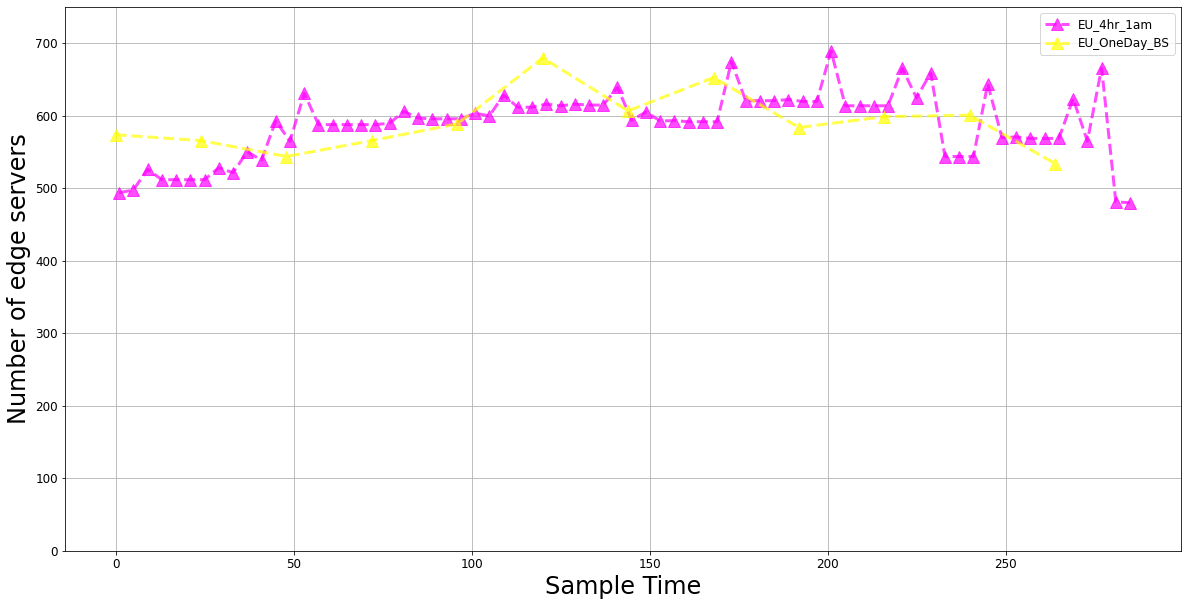

In [31]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [24*d for d in range(12)]
x_axis1 = [4*d+1 for d in range(12*6)]
color_idx = np.linspace(0, 1, 2)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

# plt.plot(x_axis, estimate_N_24hr_12pm_1hr_us[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='US_24hr_12pm', alpha=0.7)
# plt.plot(x_axis, BS_24hr_12am_us_1day[1:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='US_OneDay_BS', alpha=0.7)
ax.set_ylim(bottom=0, top=750)

plt.plot(x_axis1, estimate_N_4hr_1am_1hr_eu[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='EU_4hr_1am', alpha=0.7)
plt.plot(x_axis, BS_24hr_12am_eu_1day[1:-1], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='EU_OneDay_BS', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

visualization

In [221]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

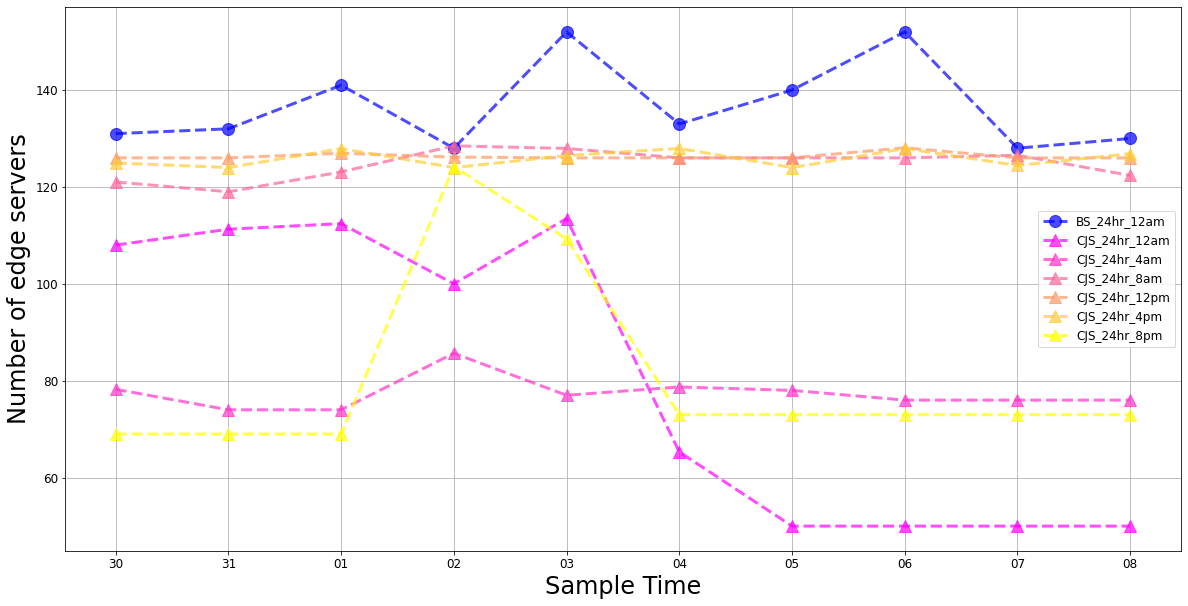

In [226]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['30', '31', '01', '02', '03', '04', '05', '06', '07', '08']
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis, BS_24hr_12am[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)


plt.plot(x_axis, estimate_N_24hr_12am_1hr[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_4am[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_24hr_4am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_8am[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_24hr_8am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_24hr_12pm', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_4pm[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_24hr_4pm', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_8pm[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

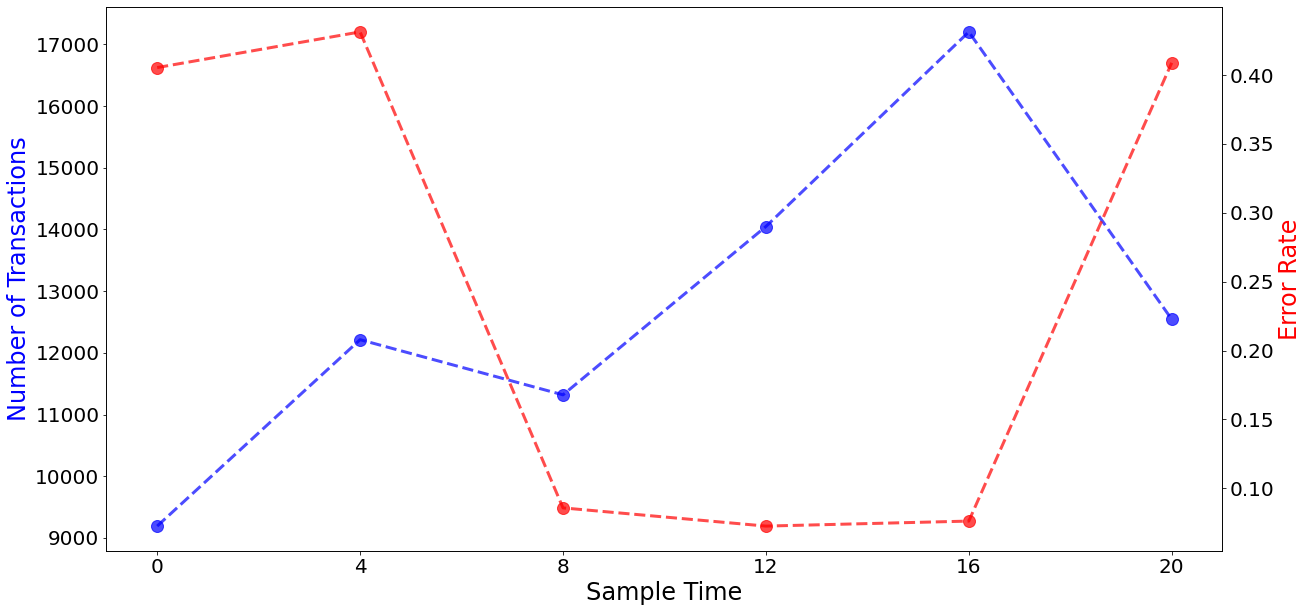

In [238]:
# transactions and error rate
fig, ax1 = plt.subplots(figsize=(20, 10))
x_axis = ['0', '4', '8', '12', '16', '20']
ax1.set_xlabel('Sample Time', fontsize=24)
ax1.set_ylabel('Number of Transactions', color='b', fontsize=24)
C_tran_table_24hr = np.zeros((6,))
C_tran_table_24hr[0] = np.mean(C_tran_24hr_12am_1hr[2:-2])
C_tran_table_24hr[1] = np.mean(C_tran_24hr_4am[2:-2])
C_tran_table_24hr[2] = np.mean(C_tran_24hr_8am[2:-2])
C_tran_table_24hr[3] = np.mean(C_tran_24hr_12pm_1hr[2:-2])
C_tran_table_24hr[4] = np.mean(C_tran_24hr_4pm[2:-2])
C_tran_table_24hr[5] = np.mean(C_tran_24hr_8pm[2:-2])

ax1.plot(x_axis, C_tran_table_24hr, "o--", markersize=12, linewidth=3, color='b', alpha=0.7)

# leg.set_title('Sampling Duration',prop={'size':20})

ax1.tick_params(axis='both', which='major', labelsize=20)

err_rate_24hr = np.zeros((6,))
err_rate_24hr[0] = np.sqrt(np.mean(np.abs(estimate_N_24hr_12am_1hr[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[1] = np.sqrt(np.mean(np.abs(estimate_N_24hr_4am[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[2] = np.sqrt(np.mean(np.abs(estimate_N_24hr_8am[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[3] = np.sqrt(np.mean(np.abs(estimate_N_24hr_12pm_1hr[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[4] = np.sqrt(np.mean(np.abs(estimate_N_24hr_4pm[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[5] = np.sqrt(np.mean(np.abs(estimate_N_24hr_8pm[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)

ax2 = ax1.twinx()
ax2.set_ylabel('Error Rate', color='r', fontsize=24)  # we already handled the x-label with ax1
ax2.plot(x_axis, err_rate_24hr, "o--", markersize=12, linewidth=3, color='r', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.show()

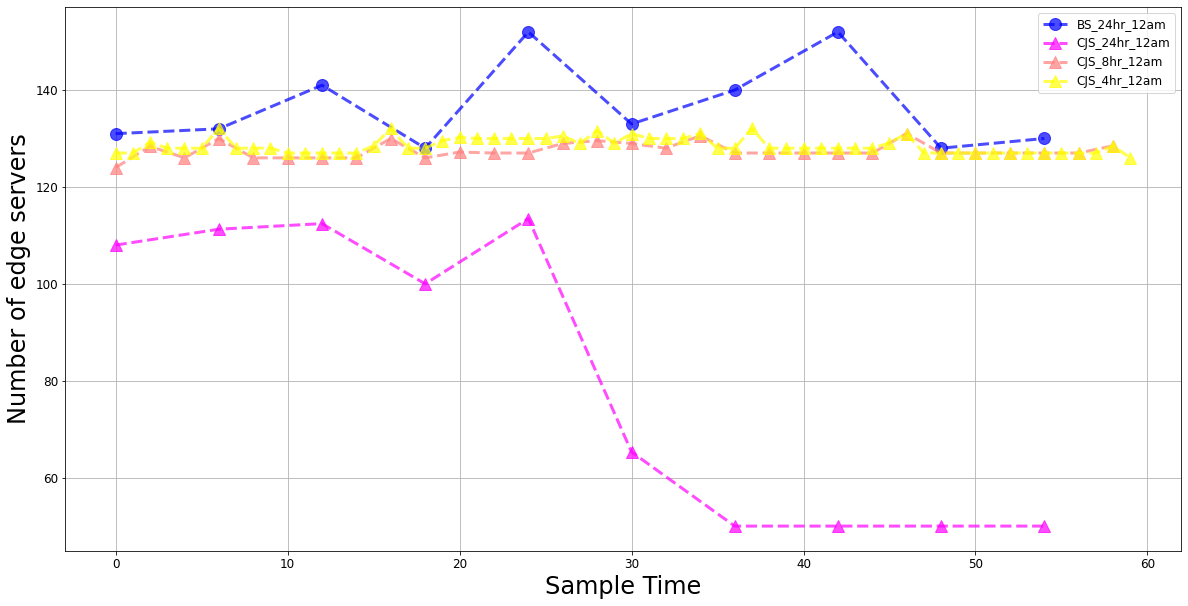

In [241]:
# CJS 12 am / 1 hr / 24 hr or 8 hr or 4 hr 
fig, ax = plt.subplots(figsize=(20, 10))
date = ['30', '31', '01', '02', '03', '04', '05', '06', '07', '08']
x_axis1 = [6*d for d in range(10)]
x_axis2 = [2*d for d in range(10*3)]
x_axis3 = [d for d in range(10*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_12am[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_12am_1hr[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_12am_60min[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am_60min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

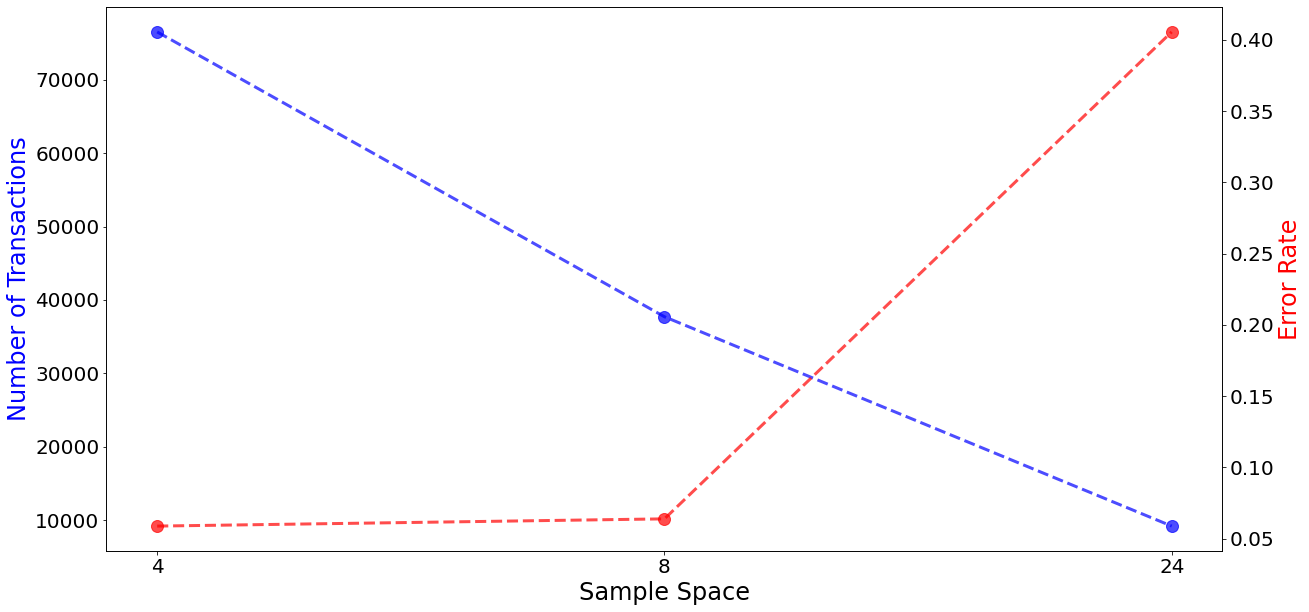

In [245]:
# transactions and error rate
fig, ax1 = plt.subplots(figsize=(20, 10))
x_axis = ['4', '8', '24']
ax1.set_xlabel('Sample Space', fontsize=24)
ax1.set_ylabel('Number of Transactions', color='b', fontsize=24)
C_tran_table_24hr = np.zeros((3,))
C_tran_table_24hr[2] = np.mean(C_tran_24hr_12am_1hr[2:-2])
C_tran_table_24hr[1] = np.mean(C_tran_8hr_12am_60min[6:-6])*3
C_tran_table_24hr[0] = np.mean(C_tran_4hr_12am_60min[12:-12])*6

ax1.plot(x_axis, C_tran_table_24hr, "o--", markersize=12, linewidth=3, color='b', alpha=0.7)

# leg.set_title('Sampling Duration',prop={'size':20})

ax1.tick_params(axis='both', which='major', labelsize=20)

err_rate_24hr = np.zeros((3,))
err_rate_24hr[2] = np.sqrt(np.mean(np.abs(estimate_N_24hr_12am_1hr[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[1] = np.sqrt(np.mean(np.abs(estimate_N_8hr_12am_60min[6:-6] - np.repeat(BS_24hr_12am[2:-2], 3))/np.repeat(BS_24hr_12am[2:-2], 3))**2)
err_rate_24hr[0] = np.sqrt(np.mean(np.abs(estimate_N_4hr_12am_60min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)

ax2 = ax1.twinx()
ax2.set_ylabel('Error Rate', color='r', fontsize=24)  # we already handled the x-label with ax1
ax2.plot(x_axis, err_rate_24hr, "o--", markersize=12, linewidth=3, color='r', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.show()

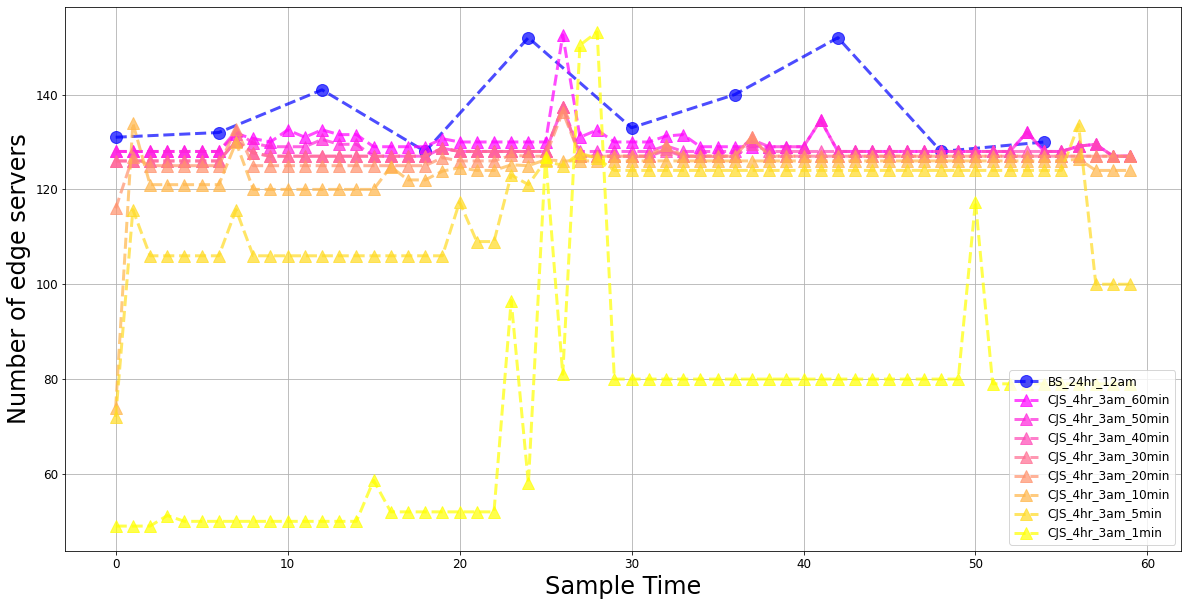

In [277]:
#CJS 4hr 3am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(10)]
x_axis1 = [d for d in range(10*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_3am_60min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_3am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_50min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_3am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_40min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_3am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_30min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_20min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_3am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_10min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_3am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_5min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_3am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_1min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_3am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12, loc=4)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

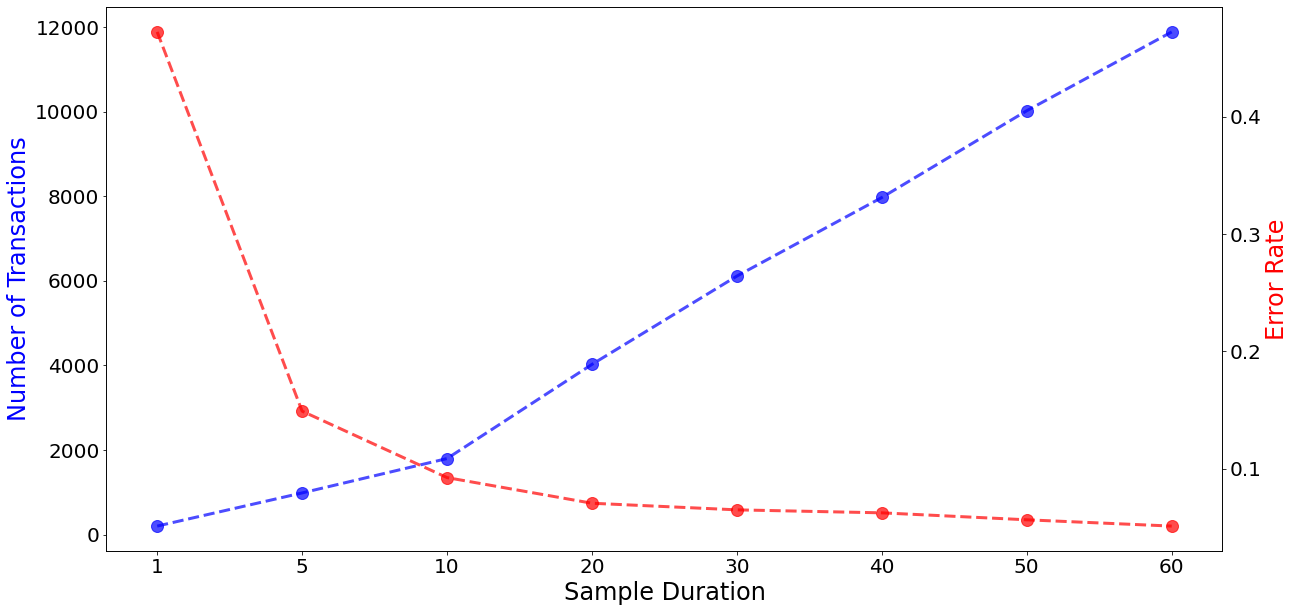

In [275]:
# transactions and error rate
fig, ax1 = plt.subplots(figsize=(20, 10))
x_axis = ['1', '5', '10', '20', '30', '40', '50', '60']
ax1.set_xlabel('Sample Duration', fontsize=24)
ax1.set_ylabel('Number of Transactions', color='b', fontsize=24)
C_tran_table = np.zeros((8,))
C_tran_table[7] = np.mean(C_tran_4hr_3am_60min[12:-12])
C_tran_table[6] = np.mean(C_tran_4hr_3am_50min[12:-12])
C_tran_table[5] = np.mean(C_tran_4hr_3am_40min[12:-12])
C_tran_table[4] = np.mean(C_tran_4hr_3am_30min[12:-12])
C_tran_table[3] = np.mean(C_tran_4hr_3am_20min[12:-12])
C_tran_table[2] = np.mean(C_tran_4hr_3am_10min[12:-12])
C_tran_table[1] = np.mean(C_tran_4hr_3am_5min[12:-12])
C_tran_table[0] = np.mean(C_tran_4hr_3am_1min[12:-12])

ax1.plot(x_axis, C_tran_table, "o--", markersize=12, linewidth=3, color='b', alpha=0.7)

# leg.set_title('Sampling Duration',prop={'size':20})

ax1.tick_params(axis='both', which='major', labelsize=20)

err_rate = np.zeros((8,))
err_rate[7] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_60min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[6] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_50min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[5] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_40min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[4] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_30min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[3] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_20min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[2] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_10min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[1] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_5min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[0] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_1min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)

ax2 = ax1.twinx()
ax2.set_ylabel('Error Rate', color='r', fontsize=24)  # we already handled the x-label with ax1
ax2.plot(x_axis, err_rate, "o--", markersize=12, linewidth=3, color='r', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.show()

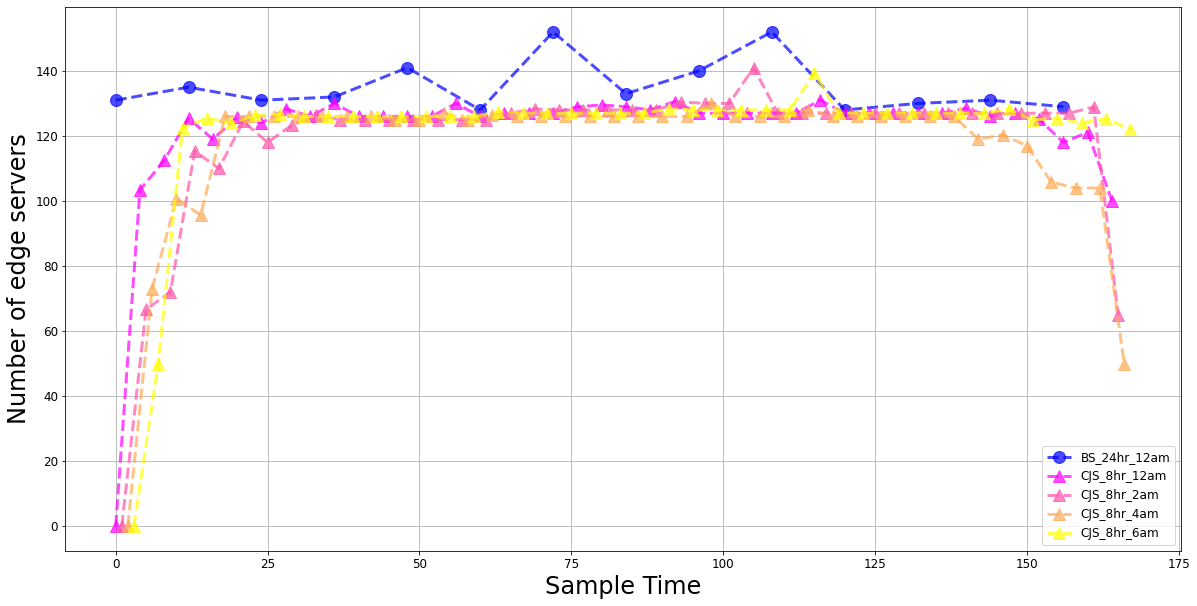

In [162]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [12*d for d in range(14)]
x_axis1 = [4*d for d in range(14*3)]
x_axis2 = [4*d+1 for d in range(14*3)]
x_axis3 = [4*d+2 for d in range(14*3)]
x_axis4 = [4*d+3 for d in range(14*3)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_2am', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_4am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_4am', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_6am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_6am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

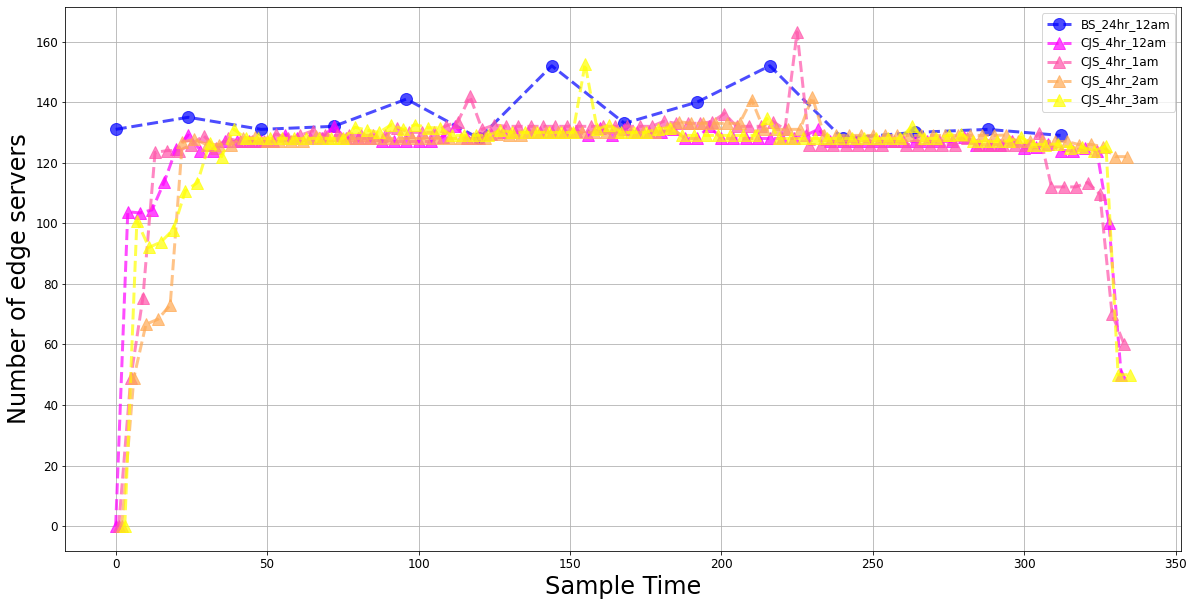

In [163]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [24*d for d in range(14)]
x_axis1 = [4*d for d in range(14*6)]
x_axis2 = [4*d+1 for d in range(14*6)]
x_axis3 = [4*d+2 for d in range(14*6)]
x_axis4 = [4*d+3 for d in range(14*6)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_1am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_1am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_2am', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_3am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

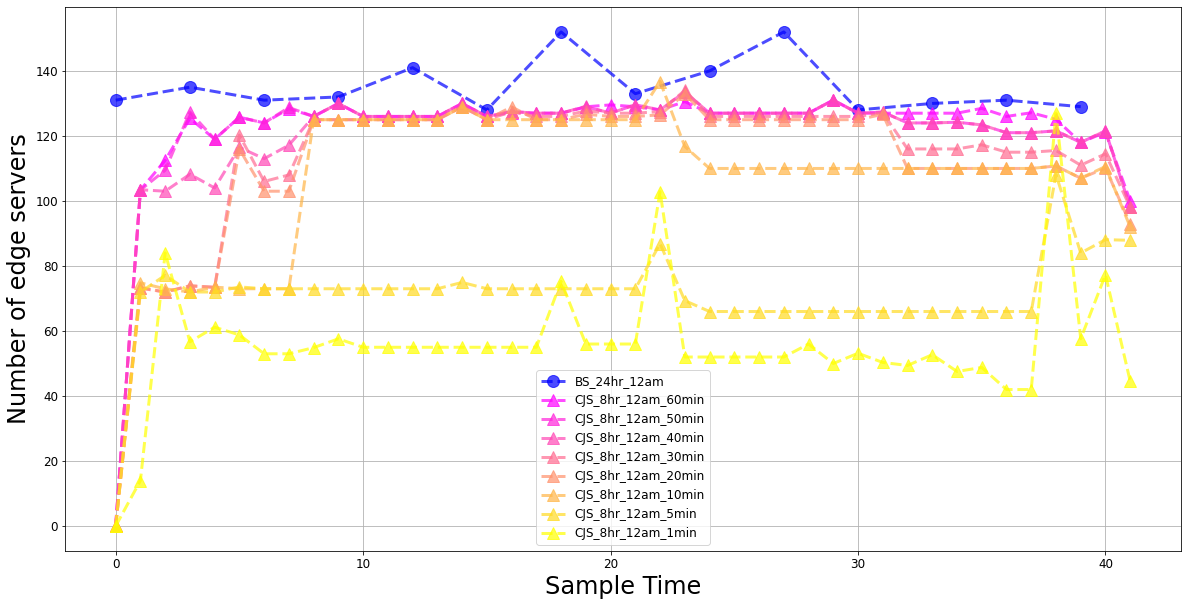

In [164]:
#CJS 8hr 12am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_12am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_12am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_12am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_12am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_12am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_12am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_12am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_12am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

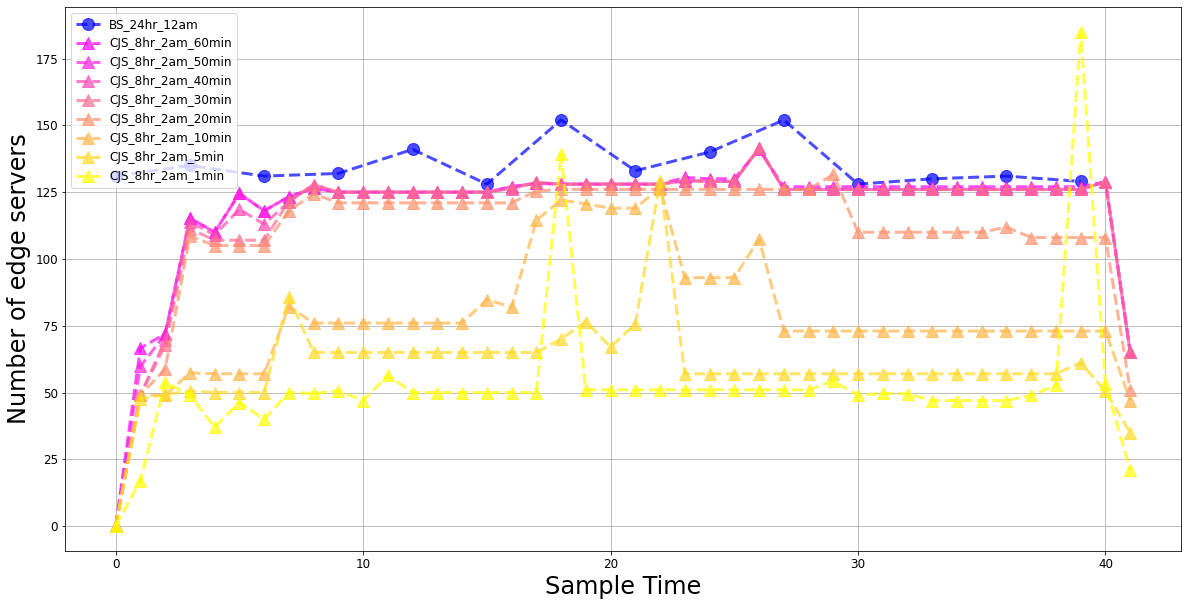

In [165]:
#CJS 8hr 2am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_2am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_2am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_2am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_2am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_2am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_2am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_2am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_2am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

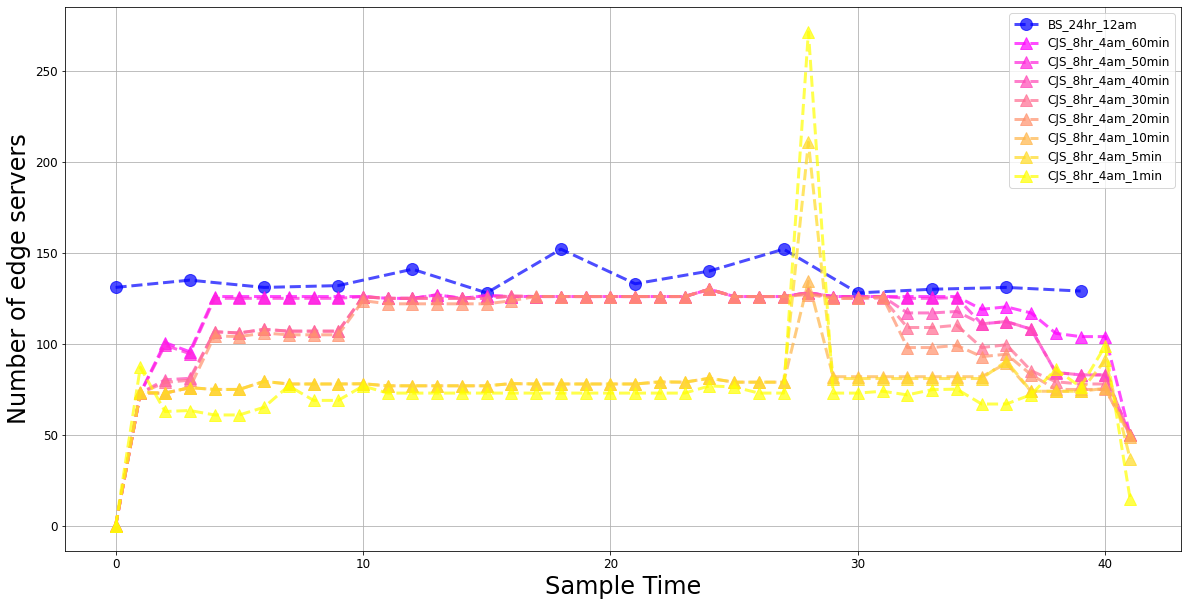

In [166]:
#CJS 8hr 4am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_4am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_4am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_4am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_4am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_4am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_4am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_4am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_4am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_4am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

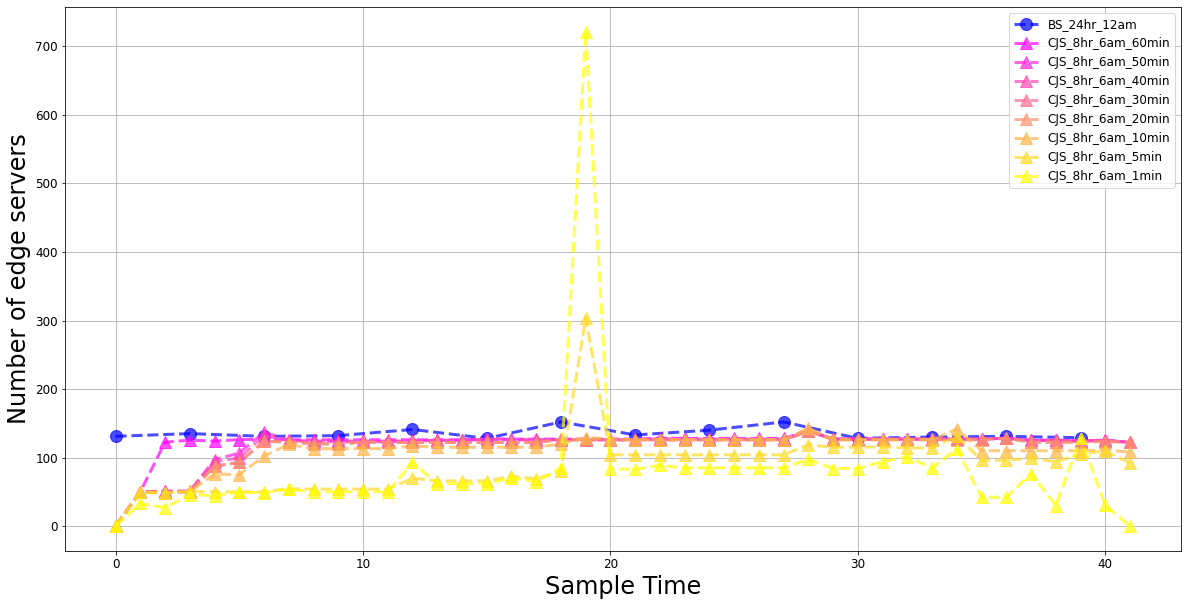

In [167]:
#CJS 8hr 6am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_6am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_6am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_6am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_6am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_6am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_6am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_6am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_6am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_6am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

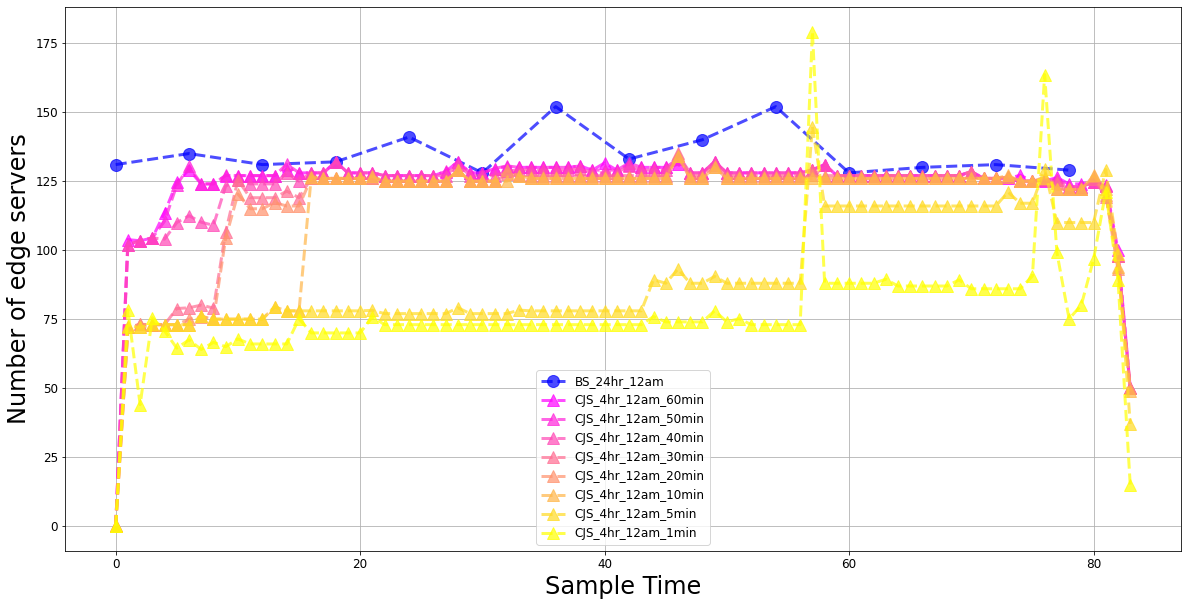

In [168]:
#CJS 4hr 12am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_12am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_12am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_12am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_12am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_12am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_12am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_12am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

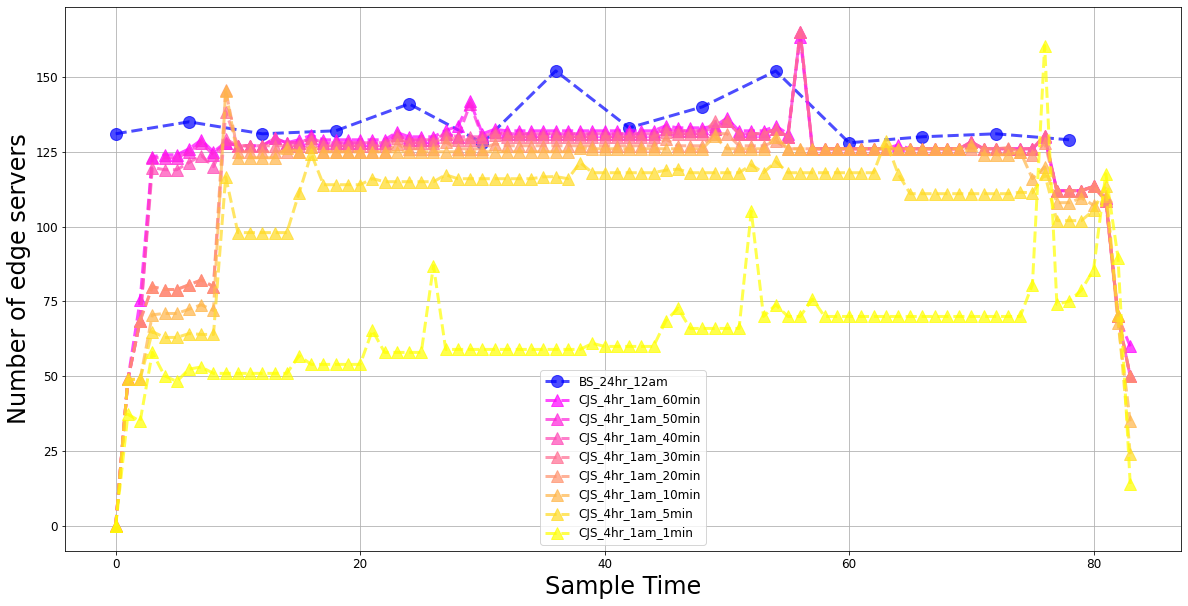

In [169]:
#CJS 4hr 1am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_1am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_1am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_1am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_1am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_1am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_1am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_1am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_1am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_1am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

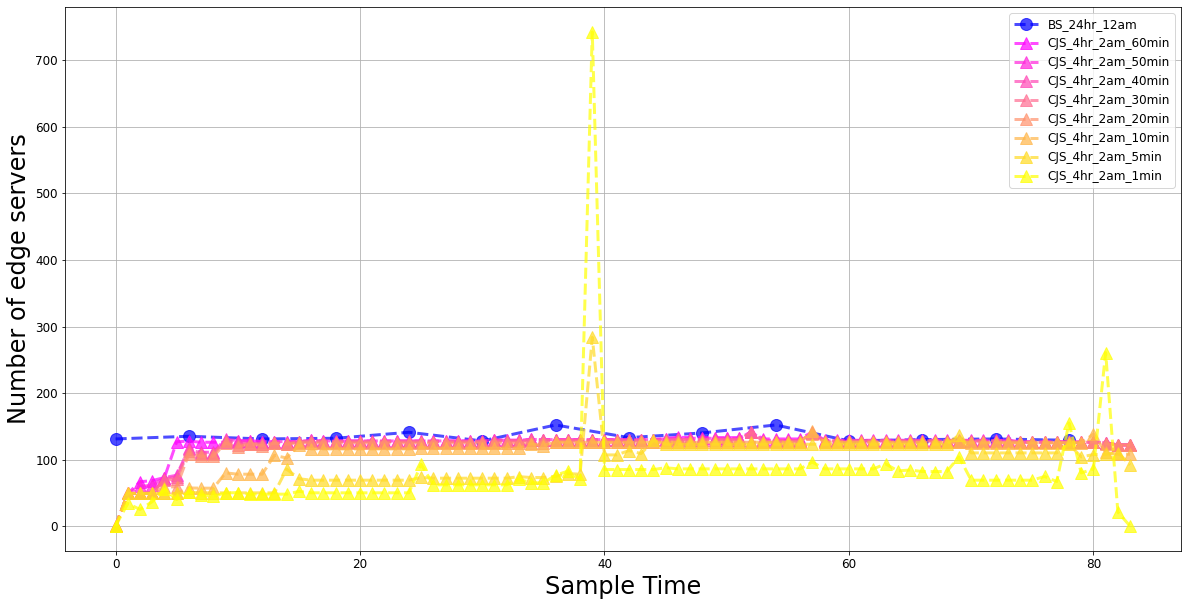

In [170]:
#CJS 4hr 2am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_2am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_2am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_2am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_2am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_2am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_2am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_2am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_2am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

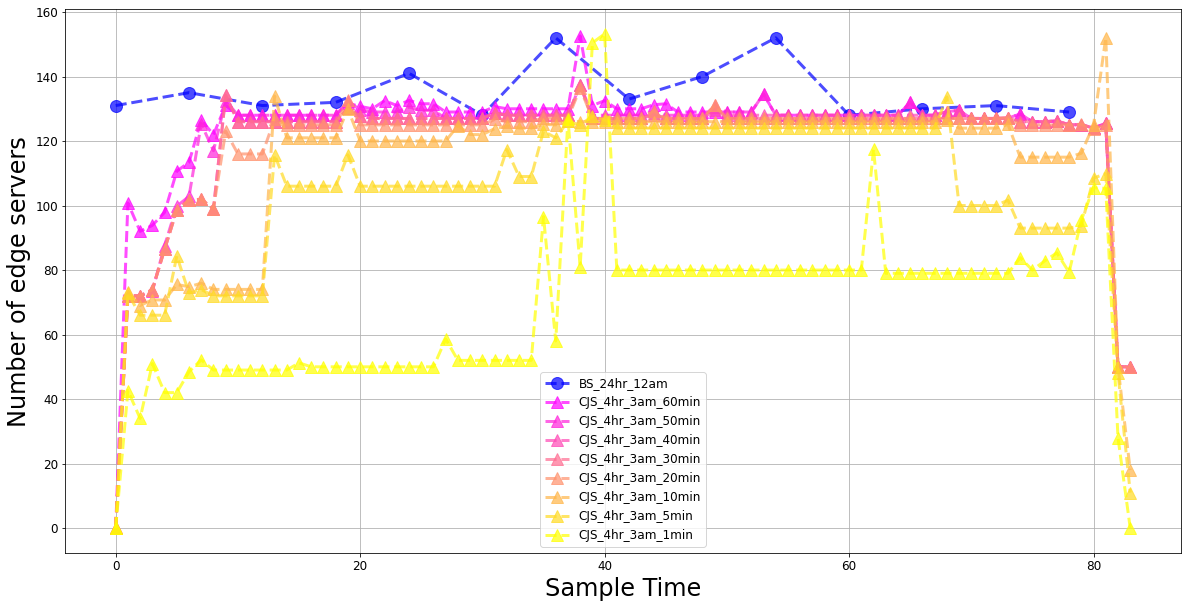

In [271]:
#CJS 4hr 3am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_3am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_3am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_3am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_3am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_3am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_3am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_3am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_3am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

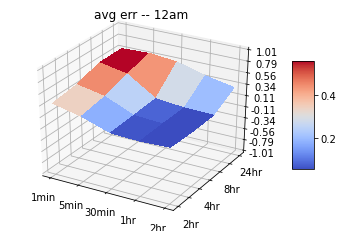

In [356]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12am, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err -- 12am")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

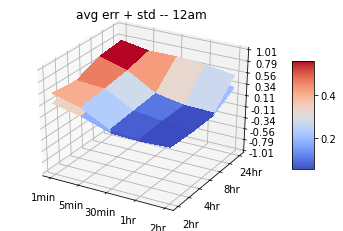

In [357]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12am + error_rate_std_12am, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, error_rate_avg_12am, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err + std -- 12am")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

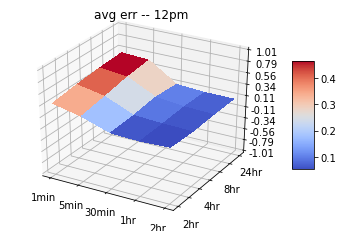

In [358]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12pm, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err -- 12pm")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

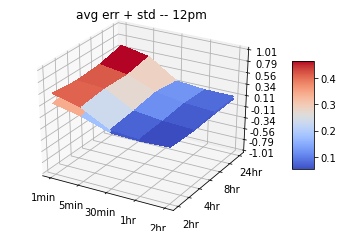

In [359]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12pm + error_rate_std_12pm, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, error_rate_avg_12pm, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err + std -- 12pm")


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [313]:
print(error_rate_avg_12am)
print(error_rate_std_12am)
print(error_rate_avg_12pm)
print(error_rate_std_12pm)

[[0.36743839 0.24621109 0.06165547 0.04113952 0.06588765]
 [0.43007837 0.32623196 0.08663453 0.05752873 0.04218574]
 [0.57808441 0.47209643 0.1149862  0.06347418 0.05042935]
 [0.58515917 0.60909722 0.55608618 0.40550324 0.29674945]]
[[0.19119541 0.17053482 0.06218337 0.04386424 0.04899264]
 [0.08081887 0.14599297 0.08695114 0.04904398 0.03622883]
 [0.11724517 0.06680818 0.09851867 0.05165655 0.04618773]
 [0.16360176 0.04512721 0.10184841 0.20903678 0.23961032]]
[[0.36743839 0.24621109 0.06165547 0.04113952 0.06588765]
 [0.43007837 0.32623196 0.08663453 0.05752873 0.04218574]
 [0.4753174  0.41729867 0.14560073 0.08523024 0.06290409]
 [0.50242851 0.47182658 0.10829144 0.07250395 0.07034315]]
[[0.19119541 0.17053482 0.06218337 0.04386424 0.04899264]
 [0.08081887 0.14599297 0.08695114 0.04904398 0.03622883]
 [0.06823002 0.0396337  0.09807384 0.06437682 0.05225091]
 [0.14689716 0.07208281 0.06931775 0.05390804 0.05436843]]
